In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import pandas as pd
import numpy as np
import math
import sklearn
import itertools

from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(9 , 6)})
sns.set_theme()

In [27]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'no_of_bathrooms', 'no_of_bedrooms', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data.head()

,latitude,longitude,no_of_bathrooms,no_of_bedrooms,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,25.113208,55.138932,2,1,2700000,100.242337,1.0,0.0,2.0
1,25.106809,55.151201,2,2,2850000,146.972546,1.0,0.0,2.0
2,25.063302,55.137728,5,3,1150000,181.253753,1.0,0.0,2.0
3,25.227295,55.341761,3,2,2850000,187.664060,1.0,0.0,1.0
4,25.114275,55.139764,1,0,1729200,47.101821,0.0,0.0,2.0


## Algoritmos de validación

In [28]:
class RandomSimpleValidation :
   
    # D --> have to be a pandas data frame.
    # k --> is the proportion of observation of D that define D_train.
    # response --> have to be a string with the name of the response variable.
    # model --> object containing the initialized model to use.
    # The function has been created thinking that the model to be used will be one from the `sklearn` library.
    # metric --> It's the name of the validation metric.
    # random_seed --> seed to replicate the random process.
    
    
    
    def __init__(self, k, metric, model, random_seed):

        self.k = k
        
        self.metric = metric
        
        self.model = model

        self.random_seed = random_seed
    

    def fit(self, D, response_name):
    
         
        N = len(D)

        self.D_train = D.sample(frac=self.k, replace=False, random_state=self.random_seed)

        self.D_test = D.drop( self.D_train.index , )

        self.X_train = self.D_train.loc[: , self.D_train.columns != response_name]
        self.Y_train = self.D_train.loc[: , response_name]

        self.X_test = self.D_test.loc[: , self.D_test.columns != response_name]
        self.Y_test = self.D_test.loc[: , response_name]


        self.model.fit(self.X_train, self.Y_train)
        
    
    def predict(self):
    
        self.Y_predict_test = self.model.predict(self.X_test)

    
    def compute_metric(self):
    
        if self.metric == 'ECM':

            self.ECM_test = np.mean((self.Y_predict_test - self.Y_test) ** 2)
            
            return self.ECM_test


        elif self.metric == 'TAC':

            self.TAC_test = np.mean((self.Y_predict_test == self.Y_test))

            return self.TAC_test

In [36]:
class RepeatedRandomSimpleValidation :
   
    # D --> It have to be a pandas data frame.
    # B --> It's the number of iterations of the Random Simple Validation algorithm.    
    # k --> It's the proportion of observation of D that define D_train.
    # response --> It have to be a string with the name of the response variable.
    # model --> It's an object containing the initialized model to use.
    # The function has been created thinking that the model to be used will be one from the `sklearn` library.
    # metric --> It's the name of the validation metric.
    # random_seed --> It's the seed to replicate the random process
    
    def __init__(self, B, k, metric, model, random_seed):

        self.B = B

        self.k = k
        
        self.metric = metric
        
        self.model = model

        self.random_seed = random_seed

 

    def fit(self, D, response_name):
    
        self.D = D
        
        self.response_name = response_name

        np.random.seed(self.random_seed)    

        self.seed_array = np.random.randint(9999999, size=(self.B))
 
    
    def compute_metric(self):
    
        Metric_test_list = [ ]

        for b in range(0,self.B) :

            RandomSimpleValidation_init = RandomSimpleValidation(k=self.k, metric=self.metric, model=self.model, random_seed=self.seed_array[b])

            RandomSimpleValidation_init.fit(D=self.D,  response_name=self.response_name)

            RandomSimpleValidation_init.predict()

            Metric_test_list.append( RandomSimpleValidation_init.compute_metric() )


        self.Metric_test = np.mean(Metric_test_list)    

        
        return self.Metric_test

In [30]:
class KFoldCV:

    # D --> It have to be a pandas data frame.
    # K --> It's the number of folds of K-fold algorithm..
    # response_name --> It have to be a string with the name of the response variable.
    # model --> It's an object containing the initialized model to use.
    # The function has been created thinking that the model to be used will be one from the `sklearn` library.
    # metric --> It's the name of the validation metric.
    # random_seed --> It's the seed to replicate the random process.
   
    def __init__(self, D, K, response_name, random_seed, metric, model):
   
        self.D = D
   
        self.K = K
   
        self.response_name = response_name
   
        self.random_seed = random_seed
   
        self.metric = metric
   
        self.model = model
   
        self.ECM_K_FOLDS_vector = []
   
        self.TA_K_FOLDS_vector = []
   
        self.df_sample = None


    def __resample_df(self):
   
        np.random.seed(self.random_seed)
   
        sample = resample(range(0, len(self.D)), n_samples=len(self.D), replace=False)
   
        self.df_sample = pd.DataFrame({'index': range(0,len(self.D)) , 'sample':sample})


    def __get_quantiles(self):
   
        Q = []
   
        for q in np.arange(0 , 1 + 1/self.K , 1/self.K):
   
            Q.append( np.quantile( range(0, len(self.D)) , q ).round(0) )
   
        return Q
    
   
    def __train_test_split(self, q, Q):
   
        X_test = self.D.loc[self.df_sample.loc[Q[q]:(math.floor(Q[q+1])-1), 'sample'] , self.D.columns != self.response_name ] 
   
        Y_test = self.D.loc[self.df_sample.loc[Q[q]:(math.floor(Q[q+1])-1), 'sample'] , self.D.columns == self.response_name ]
   
        X_train = self.D.loc[ : , self.D.columns != self.response_name ].drop(self.df_sample.loc[Q[q]:(math.floor(Q[q+1])-1), 'sample'] )
   
        Y_train = self.D.loc[ : , self.D.columns == self.response_name ].drop(self.df_sample.loc[Q[q]:(math.floor(Q[q+1])-1), 'sample'])
   
        Y_test = Y_test.to_numpy()
   
        return X_test, Y_test, X_train, Y_train
    
   
    def fit(self):
   
        self.__resample_df()
   
        Q = self.__get_quantiles()
   
        for j in range(0, len(Q)-1):
   
            X_test, Y_test, X_train, Y_train = self.__train_test_split(j, Q)
   
            self.model.fit(X_train, Y_train)
   
            Y_predict_test = self.model.predict(X_test)
   
            if self.metric == 'ECM':
   
                self.ECM_K_FOLDS_vector.append(np.mean((Y_predict_test - Y_test)**2))
   
            elif self.metric == 'TAC':
   
                self.TA_K_FOLDS_vector.append(np.mean((Y_predict_test == Y_test)))


    def get_metric(self):
   
        if self.metric == 'ECM':
   
            return np.mean(self.ECM_K_FOLDS_vector)
   
        elif self.metric == 'TAC':
   
            return np.mean(self.TA_K_FOLDS_vector)

In [31]:
class RepeatedKFoldCV:

    # D --> It have to be a pandas data frame.
    # B --> It's the number of iterations of the K-Fold algorithm.    
    # K --> It's the number of folds of K-fold algorithm..
    # response_name --> It have to be a string with the name of the response variable.
    # model --> It's an object containing the initialized model to use.
    # The function has been created thinking that the model to be used will be one from the `sklearn` library.
    # metric --> It's the name of the validation metric.
    # random_seed --> It's the seed to replicate the random process.
    
    def __init__(self, B, K, random_seed, metric, model):
     
     
        self.B = B
     
        self.K = K
         
        self.random_seed = random_seed
     
        self.metric = metric
     
        self.model = model
        

    def fit(self, D, response_name):
       
        self.Metric_Repeted_K_Folds_list = [ ]
       
        np.random.seed(self.random_seed)

        for b in range(0, self.B):
       
            KFoldCV_init = KFoldCV(D=D, K=self.K, response_name=response_name, random_seed=123, metric=self.metric, model=self.model)

            KFoldCV_init.fit()

            self.Metric_Repeted_K_Folds_list.append( KFoldCV_init.get_metric() )


    def get_metric(self):

        return  np.mean(self.Metric_Repeted_K_Folds_list)

## Grid search 

In [32]:
import itertools
import pandas as pd
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [117]:
class GridSearch:

    def __init__(self, model, search_space, metric, random_search=False, n_random_samples=None, random_state = None):
        
        self.model = model
        self.search_space = search_space
        self.metric = metric              
        self.random_search = random_search
        self.random_state = random_state
        self.n_random_samples = n_random_samples
               

    def fit_KFoldCV(self, Data, response_name, K, random_seed):

        self.Data = Data
        self.response_name = response_name
        self.K = K
        self.random_seed = random_seed
        self.hyperparameter_combinations = list(itertools.product(self.search_space[0], self.search_space[1]))
        self.grid_search_metric_list = []

        if self.random_search:

            self.hyperparameter_combinations = resample(self.hyperparameter_combinations, n_samples=self.n_random_samples, replace=False, random_state=self.random_state)
        
        else:  pass


        if self.model == 'knn_regression' :

            for h in self.hyperparameter_combinations:
            
                knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0], metric=h[1])

                KFoldCV_init = KFoldCV(D=self.Data, K=self.K, response_name=self.response_name, 
                                       random_seed=self.random_seed, metric=self.metric, model=knn_regression_init)

                KFoldCV_init.fit()

                self.grid_search_metric_list.append(KFoldCV_init.get_metric())            


        elif self.model == 'knn_classification' :

            for h in self.hyperparameter_combinations:
            
                knn_classification_init = sklearn.neighbors.KNeighborsClassifier(n_neighbors=h[0], metric=h[1])

                KFoldCV_init = KFoldCV(D=self.Data, K=self.K, response_name=self.response_name,
                                       random_seed=self.random_seed, metric=self.metric, model=knn_classification_init)

                KFoldCV_init.fit()

                self.grid_search_metric_list.append(KFoldCV_init.get_metric()) 



    def fit_RepeatedRandomSimpleValidation(self, Data, response_name, k, B, random_seed):

        self.Data = Data
        self.response_name = response_name
        self.k = k
        self.B = B
        self.random_seed = random_seed
        self.hyperparameter_combinations = list(itertools.product(self.search_space[0], self.search_space[1]))
        self.grid_search_metric_list = []

        if self.random_search:

            self.hyperparameter_combinations = resample(self.hyperparameter_combinations, n_samples=self.n_random_samples, replace=False, random_state=self.random_state)
        
        else:

            pass


        if self.model == 'knn_regression' :

            for h in self.hyperparameter_combinations:
            
                knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0], metric=h[1])

                RepeatedRandomSimpleValidation_init = RepeatedRandomSimpleValidation(B=self.B, k=self.k, metric=self.metric, 
                                                                                     model=knn_regression_init, random_seed=self.random_seed)

                RepeatedRandomSimpleValidation_init.fit(D=self.Data, response_name=self.response_name)

                self.grid_search_metric_list.append(RepeatedRandomSimpleValidation_init.compute_metric())            


        elif self.model == 'knn_classification' :

            for h in self.hyperparameter_combinations:
            
                knn_classification_init = sklearn.neighbors.KNeighborsClassifier(n_neighbors=h[0], metric=h[1])

                RepeatedRandomSimpleValidation_init = RepeatedRandomSimpleValidation(B=self.B, k=self.k, metric=self.metric,
                                                                                     model=knn_classification_init, random_seed=self.random_seed)

                RepeatedRandomSimpleValidation_init.fit(D=self.Data, response_name=self.response_name)

                self.grid_search_metric_list.append(RepeatedRandomSimpleValidation_init.compute_metric())            




    def fit_RepeatedKFoldCV(self, Data, response_name, K, B, random_seed):

        self.Data = Data
        self.response_name = response_name
        self.K = K
        self.B = B
        self.random_seed = random_seed
        self.hyperparameter_combinations = list(itertools.product(self.search_space[0], self.search_space[1]))
        self.grid_search_metric_list = []

        if self.random_search:

            self.hyperparameter_combinations = resample(self.hyperparameter_combinations, n_samples=self.n_random_samples, 
                                                        replace=False, random_state=self.random_state)
        
        else:

            pass


        if self.model == 'knn_regression' :

            for h in self.hyperparameter_combinations:
            
                knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0], metric=h[1])

                RepeatedKFoldCV_init = RepeatedKFoldCV(B=self.B, K=self.K, metric=self.metric, 
                                                        model=knn_regression_init, random_seed=self.random_seed)

                RepeatedKFoldCV_init.fit(D=self.Data, response_name=self.response_name)

                self.grid_search_metric_list.append(RepeatedKFoldCV_init.get_metric())            


        elif self.model == 'knn_classification' :

            for h in self.hyperparameter_combinations:
            
                knn_classification_init = sklearn.neighbors.KNeighborsClassifier(n_neighbors=h[0], metric=h[1])

                RepeatedKFoldCV_init = RepeatedKFoldCV(B=self.B, K=self.K, metric=self.metric, 
                                                                      model=knn_classification_init, random_seed=self.random_seed)

                RepeatedKFoldCV_init.fit(D=self.Data, response_name=self.response_name)

                self.grid_search_metric_list.append(RepeatedKFoldCV_init.get_metric())             

        
    def get_df_grid_search(self) :

            self.df_grid_search = pd.DataFrame({'(k, distance)': self.hyperparameter_combinations, self.metric: self.grid_search_metric_list})

            if self.metric == 'ECM':

                self.df_grid_search = self.df_grid_search.sort_values(by=self.metric, ascending=True)
        
            elif self.metric == 'TAC':
        
                self.df_grid_search = self.df_grid_search.sort_values(by=self.metric, ascending=False)

            return self.df_grid_search


In [84]:
search_space = [range(1,100) , ['euclidean','cosine','cityblock','manhattan']]

## GridSearch_10Fold_regression

In [166]:
GridSearch_init = GridSearch( model='knn_regression', search_space=search_space, metric='ECM')

In [167]:
GridSearch_init.fit_KFoldCV(Data=Data, response_name='price', K=10, random_seed=123)

time: 1.23 min

In [168]:
GridSearch_10Fold_regression = GridSearch_init.get_df_grid_search()

In [169]:
GridSearch_10Fold_regression

,"(k, distance)",ECM
30,"(8, cityblock)",2.149765e+12
31,"(8, manhattan)",2.149765e+12
28,"(8, euclidean)",2.167357e+12
69,"(18, cosine)",2.172008e+12
33,"(9, cosine)",2.179763e+12
...,...,...
391,"(98, manhattan)",4.028750e+12
388,"(98, euclidean)",4.032013e+12
394,"(99, cityblock)",4.048032e+12
395,"(99, manhattan)",4.048032e+12


## RandomSearch_10Fold_regression

In [170]:
RandomSearch_init = GridSearch( model='knn_regression', search_space=search_space, metric='ECM', random_search=True, n_random_samples=150, random_state=123)

In [171]:
RandomSearch_init.fit_KFoldCV(Data=Data, response_name='price', K=10, random_seed=123)

time: 25.8 seg

In [172]:
RandomSearch_10Fold_regression = RandomSearch_init.get_df_grid_search()

RandomSearch_10Fold_regression

,"(k, distance)",ECM
60,"(8, manhattan)",2.149765e+12
107,"(8, cityblock)",2.149765e+12
13,"(9, cosine)",2.179763e+12
138,"(14, cosine)",2.183241e+12
18,"(11, cosine)",2.197101e+12
...,...,...
36,"(97, euclidean)",4.016359e+12
53,"(98, manhattan)",4.028750e+12
134,"(99, cityblock)",4.048032e+12
130,"(99, manhattan)",4.048032e+12


## GridSearch_10Fold_classification

In [173]:
GridSearch_init = GridSearch( model='knn_classification', search_space=search_space, metric='TAC')

In [174]:
GridSearch_init.fit_KFoldCV(Data=Data, response_name='quality_recode', K=10, random_seed=123)

time: 1.24 min

In [175]:
GridSearch_10Fold_classification = GridSearch_init.get_df_grid_search()

In [176]:
GridSearch_10Fold_classification

,"(k, distance)",TAC
395,"(99, manhattan)",0.601334
327,"(82, manhattan)",0.601334
312,"(79, euclidean)",0.601334
314,"(79, cityblock)",0.601334
315,"(79, manhattan)",0.601334
...,...,...
1,"(1, cosine)",0.450322
5,"(2, cosine)",0.381866
7,"(2, manhattan)",0.375512
6,"(2, cityblock)",0.375512


## RandomSearch_10Fold_classification

In [177]:
RandomSearch_init = GridSearch( model='knn_classification', search_space=search_space, metric='TAC', random_search=True, random_state=123)

In [178]:
RandomSearch_init.fit_KFoldCV(Data=Data, response_name='quality_recode', K=10, random_seed=123)

time: 1.34 min

In [179]:
RandomSearch_10Fold_classification = RandomSearch_init.get_df_grid_search()

RandomSearch_10Fold_classification

,"(k, distance)",TAC
395,"(92, cosine)",0.601334
141,"(71, manhattan)",0.601334
130,"(99, manhattan)",0.601334
301,"(74, cityblock)",0.601334
134,"(99, cityblock)",0.601334
...,...,...
322,"(1, cosine)",0.450322
121,"(2, cosine)",0.381866
82,"(2, cityblock)",0.375512
182,"(2, manhattan)",0.375512


## GridSearch_5_Repeated_10Fold_regression

In [180]:
GridSearch_init = GridSearch(model='knn_regression', search_space=search_space, metric='ECM')

In [181]:
GridSearch_init.fit_RepeatedKFoldCV(Data=Data, response_name='price', B=5, K=10, random_seed=123)

time: 5.32 min

In [182]:
GridSearch_5_Repeated_10Fold_regression = GridSearch_init.get_df_grid_search()

GridSearch_5_Repeated_10Fold_regression

,"(k, distance)",ECM
30,"(8, cityblock)",2.149765e+12
31,"(8, manhattan)",2.149765e+12
28,"(8, euclidean)",2.167357e+12
69,"(18, cosine)",2.172008e+12
33,"(9, cosine)",2.179763e+12
...,...,...
391,"(98, manhattan)",4.028750e+12
388,"(98, euclidean)",4.032013e+12
394,"(99, cityblock)",4.048032e+12
395,"(99, manhattan)",4.048032e+12


## RandomSearch_5_Repeated_10Fold_regression

In [183]:
RandomSearch_init = GridSearch(model='knn_regression', search_space=search_space, metric='ECM', random_search=True, n_random_samples=150, random_state=123)

In [184]:
RandomSearch_init.fit_RepeatedKFoldCV(Data=Data, response_name='quality_recode', B=5, K=10, random_seed=123)

time: 1.48 seg

In [185]:
RandomSearch_5_Repeated_10Fold_regression = RandomSearch_init.get_df_grid_search()

RandomSearch_5_Repeated_10Fold_regression

,"(k, distance)",ECM
145,"(88, cosine)",0.457656
113,"(85, cosine)",0.457697
21,"(84, cosine)",0.458074
12,"(97, cosine)",0.458586
5,"(66, manhattan)",0.458723
...,...,...
19,"(3, cosine)",0.574303
26,"(3, manhattan)",0.579867
121,"(2, cosine)",0.646198
82,"(2, cityblock)",0.652763


## GridSearch_5_Repeted_10Fold_classification

In [186]:
GridSearch_init = GridSearch(model='knn_classification', search_space=search_space, metric='TAC')

In [187]:
GridSearch_init.fit_RepeatedKFoldCV(Data=Data, response_name='quality_recode', B=5, K=10, random_seed=123)

time: 7.52 min

In [188]:
GridSearch_5_Repeated_10Fold_classification = GridSearch_init.get_df_grid_search()

GridSearch_5_Repeated_10Fold_classification

,"(k, distance)",TAC
395,"(99, manhattan)",0.601334
327,"(82, manhattan)",0.601334
312,"(79, euclidean)",0.601334
314,"(79, cityblock)",0.601334
315,"(79, manhattan)",0.601334
...,...,...
1,"(1, cosine)",0.450322
5,"(2, cosine)",0.381866
7,"(2, manhattan)",0.375512
6,"(2, cityblock)",0.375512


## RandomSearch_5_Repeated_10Fold_classification

In [189]:
RandomSearch_init = GridSearch(model='knn_classification', search_space=search_space, metric='TAC', random_search=True, random_state=123)

In [190]:
RandomSearch_init.fit_RepeatedKFoldCV(Data=Data, response_name='quality_recode', B=5, K=10, random_seed=123)

In [191]:
RandomSearch_5_Repeated_10Fold_classification = RandomSearch_init.get_df_grid_search()

RandomSearch_5_Repeated_10Fold_classification

,"(k, distance)",TAC
395,"(92, cosine)",0.601334
141,"(71, manhattan)",0.601334
130,"(99, manhattan)",0.601334
301,"(74, cityblock)",0.601334
134,"(99, cityblock)",0.601334
...,...,...
322,"(1, cosine)",0.450322
121,"(2, cosine)",0.381866
82,"(2, cityblock)",0.375512
182,"(2, manhattan)",0.375512


## GridSearch_Repeated_Random_Simple_Validation_regression

In [192]:
GridSearch_init = GridSearch(model='knn_regression', search_space=search_space, metric='ECM')

In [193]:
GridSearch_init.fit_RepeatedRandomSimpleValidation(Data=Data, response_name='price', B=15, k=0.8, random_seed=123)

In [194]:
GridSearch_Repeated_Random_Simple_Validation_regression = GridSearch_init.get_df_grid_search()

GridSearch_Repeated_Random_Simple_Validation_regression

,"(k, distance)",ECM
61,"(16, cosine)",2.100355e+12
57,"(15, cosine)",2.104077e+12
65,"(17, cosine)",2.114013e+12
53,"(14, cosine)",2.129950e+12
69,"(18, cosine)",2.135545e+12
...,...,...
388,"(98, euclidean)",3.707686e+12
1,"(1, cosine)",3.716708e+12
394,"(99, cityblock)",3.716987e+12
395,"(99, manhattan)",3.716987e+12


## RandomSearch_Repeated_Simple_Validation_regression

In [195]:
GridSearch_init = GridSearch(model='knn_regression', search_space=search_space, metric='ECM', random_search=True, random_state=123, n_random_samples=150)

In [196]:
GridSearch_init.fit_RepeatedRandomSimpleValidation(Data=Data, response_name='price', B=15, k=0.8, random_seed=123)

In [197]:
RandomSearch_Repeated_Simple_Validation_regression = GridSearch_init.get_df_grid_search()

RandomSearch_Repeated_Simple_Validation_regression

,"(k, distance)",ECM
138,"(14, cosine)",2.129950e+12
62,"(15, manhattan)",2.154248e+12
106,"(14, manhattan)",2.154595e+12
6,"(14, cityblock)",2.154595e+12
131,"(18, manhattan)",2.160066e+12
...,...,...
36,"(97, euclidean)",3.697234e+12
53,"(98, manhattan)",3.705077e+12
134,"(99, cityblock)",3.716987e+12
130,"(99, manhattan)",3.716987e+12


## GridSearch_Repeated_Simple_Validation_classification

In [198]:
GridSearch_init = GridSearch(model='knn_classification', search_space=search_space, metric='TAC')

In [199]:
GridSearch_init.fit_RepeatedRandomSimpleValidation(Data=Data, response_name='quality_recode', B=15, k=0.8, random_seed=123)

In [200]:
GridSearch_Repeated_Simple_Validation_classification = GridSearch_init.get_df_grid_search()

GridSearch_Repeated_Simple_Validation_classification

,"(k, distance)",TAC
365,"(92, cosine)",0.591776
218,"(55, cityblock)",0.591601
369,"(93, cosine)",0.591601
377,"(95, cosine)",0.591601
337,"(85, cosine)",0.591601
...,...,...
12,"(4, euclidean)",0.483990
5,"(2, cosine)",0.427822
7,"(2, manhattan)",0.414523
6,"(2, cityblock)",0.414523


## RandomSearch_Repeated_Simple_Validation_classification

In [201]:
GridSearch_init = GridSearch(model='knn_classification', search_space=search_space, metric='TAC', random_search=True, random_state=123, n_random_samples=150)

In [202]:
GridSearch_init.fit_RepeatedRandomSimpleValidation(Data=Data, response_name='quality_recode', B=15, k=0.8, random_seed=123)

In [203]:
RandomSearch_Repeated_Simple_Validation_classification = GridSearch_init.get_df_grid_search()

RandomSearch_Repeated_Simple_Validation_classification

,"(k, distance)",TAC
113,"(85, cosine)",0.591601
51,"(55, cityblock)",0.591601
96,"(69, cosine)",0.591601
8,"(66, cosine)",0.591426
91,"(91, cityblock)",0.591426
...,...,...
26,"(3, manhattan)",0.490114
24,"(4, manhattan)",0.485389
103,"(4, euclidean)",0.483990
121,"(2, cosine)",0.427822


## Gráficos

In [205]:
GridSearch_10Fold_regression['(k, distance)'] = GridSearch_10Fold_regression['(k, distance)'].astype('str')
RandomSearch_10Fold_regression['(k, distance)'] = RandomSearch_10Fold_regression['(k, distance)'].astype('str')
GridSearch_10Fold_classification['(k, distance)'] = GridSearch_10Fold_classification['(k, distance)'].astype('str')
RandomSearch_10Fold_classification['(k, distance)'] = RandomSearch_10Fold_classification['(k, distance)'].astype('str')
GridSearch_5_Repeated_10Fold_regression['(k, distance)'] = GridSearch_5_Repeated_10Fold_regression['(k, distance)'].astype('str')
GridSearch_5_Repeated_10Fold_classification['(k, distance)'] = GridSearch_5_Repeated_10Fold_classification['(k, distance)'].astype('str')
RandomSearch_5_Repeated_10Fold_regression['(k, distance)'] = RandomSearch_5_Repeated_10Fold_regression['(k, distance)'].astype('str')
RandomSearch_5_Repeated_10Fold_classification['(k, distance)'] = RandomSearch_5_Repeated_10Fold_classification['(k, distance)'].astype('str')
GridSearch_Repeated_Random_Simple_Validation_regression['(k, distance)'] = GridSearch_Repeated_Random_Simple_Validation_regression['(k, distance)'].astype('str')
GridSearch_Repeated_Simple_Validation_classification['(k, distance)'] = GridSearch_Repeated_Simple_Validation_classification['(k, distance)'].astype('str')
RandomSearch_Repeated_Simple_Validation_classification['(k, distance)'] = RandomSearch_Repeated_Simple_Validation_classification['(k, distance)'].astype('str')
RandomSearch_Repeated_Simple_Validation_regression['(k, distance)'] = RandomSearch_Repeated_Simple_Validation_regression['(k, distance)'].astype('str')

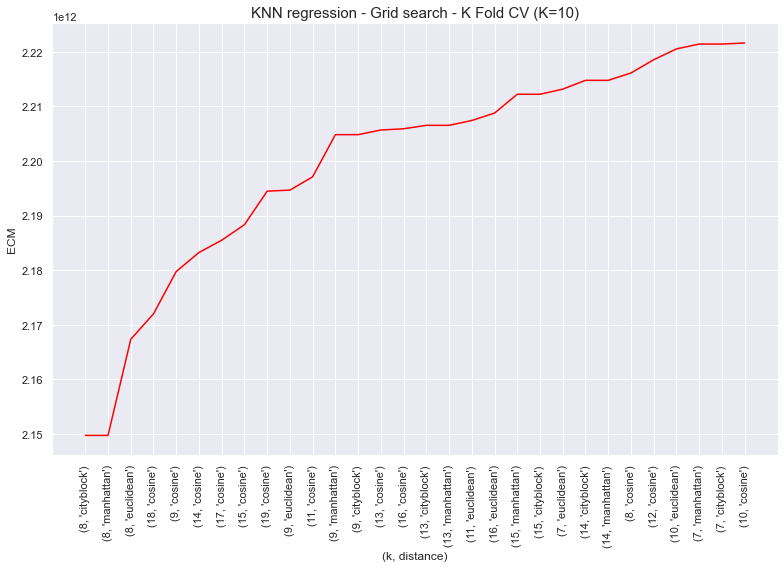

In [206]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="ECM", x='(k, distance)' , data=GridSearch_10Fold_regression.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN regression - Grid search - K Fold CV (K=10)", fontsize=15)

plt.tight_layout()

fig.savefig('p1.jpg', format='jpg', dpi=600)

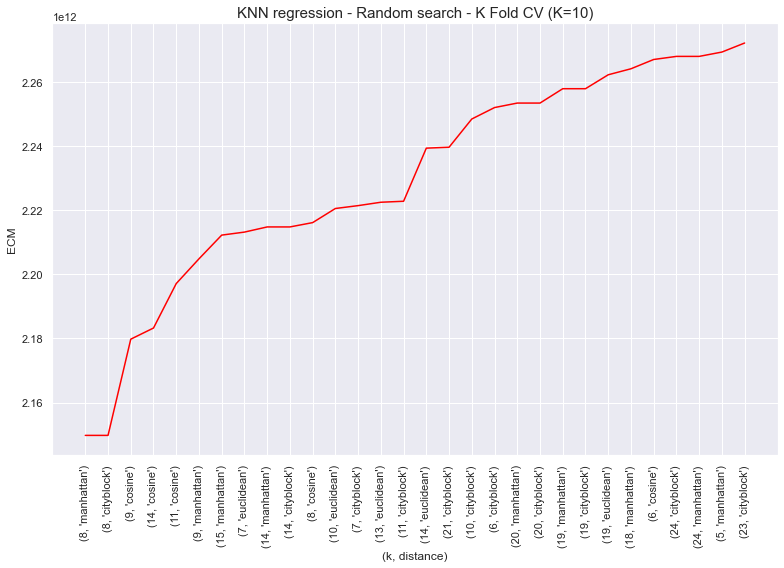

In [209]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="ECM", x='(k, distance)', data=RandomSearch_10Fold_regression.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - K Fold CV (K=10)", fontsize=15)

plt.tight_layout()

fig.savefig('p2.jpg', format='jpg', dpi=600)

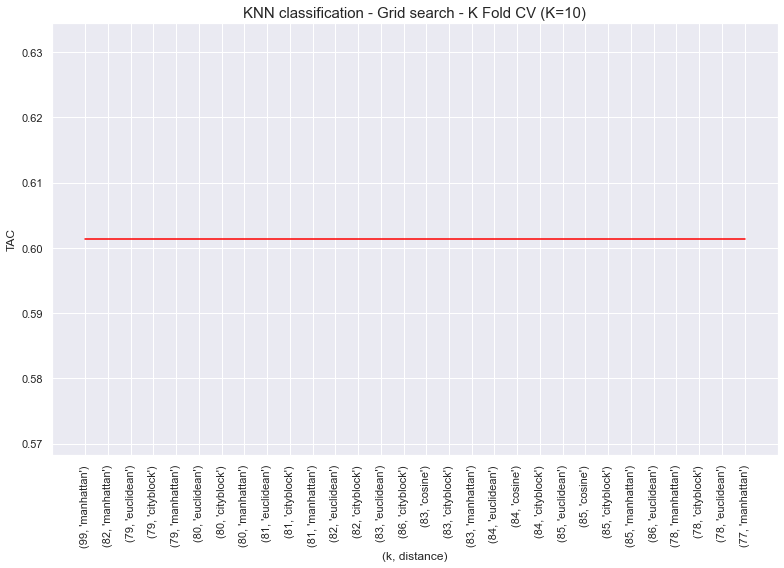

In [211]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="TAC", x='(k, distance)', data=GridSearch_10Fold_classification.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - K Fold CV (K=10)", fontsize=15)

plt.tight_layout()

fig.savefig('p3.jpg', format='jpg', dpi=600)

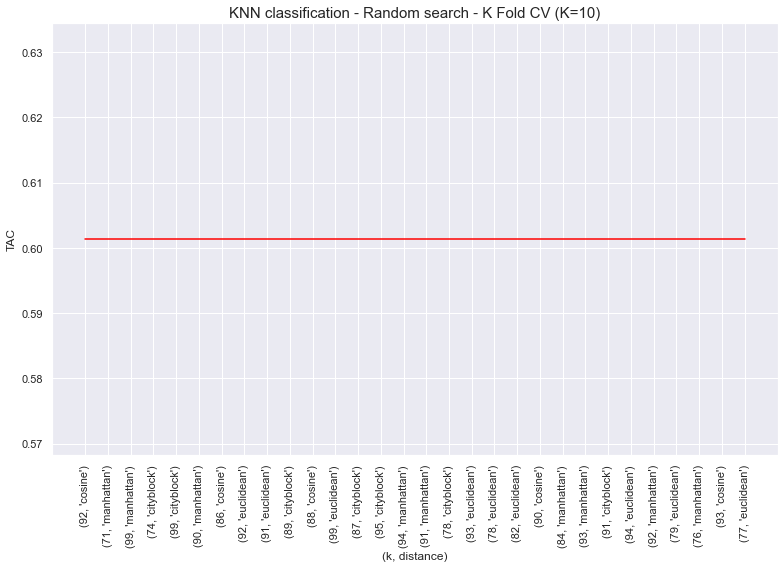

In [213]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="TAC", x='(k, distance)' , data=RandomSearch_10Fold_classification.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - K Fold CV (K=10)", fontsize=15)

plt.tight_layout()

fig.savefig('p4.jpg', format='jpg', dpi=600)

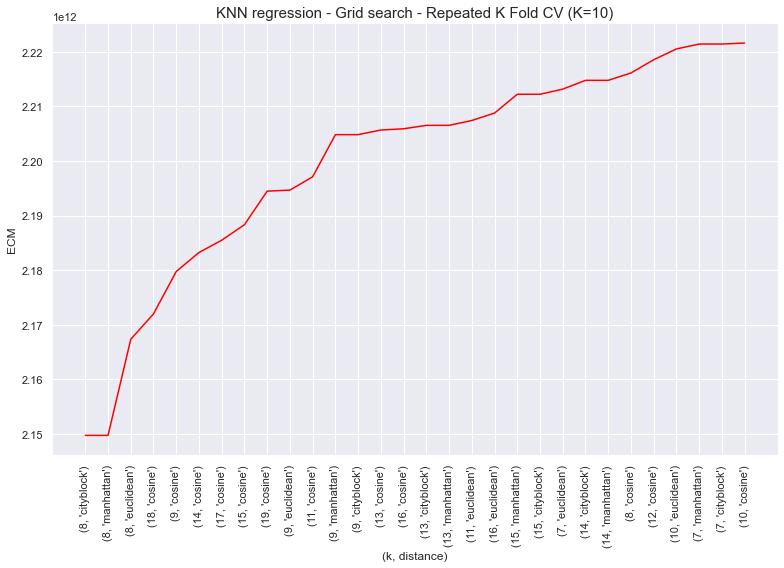

In [214]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="ECM", x='(k, distance)' , data=GridSearch_5_Repeated_10Fold_regression.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN regression - Grid search - Repeated K Fold CV (K=10, B=5)", fontsize=15)

plt.tight_layout()

fig.savefig('p5.jpg', format='jpg', dpi=600)

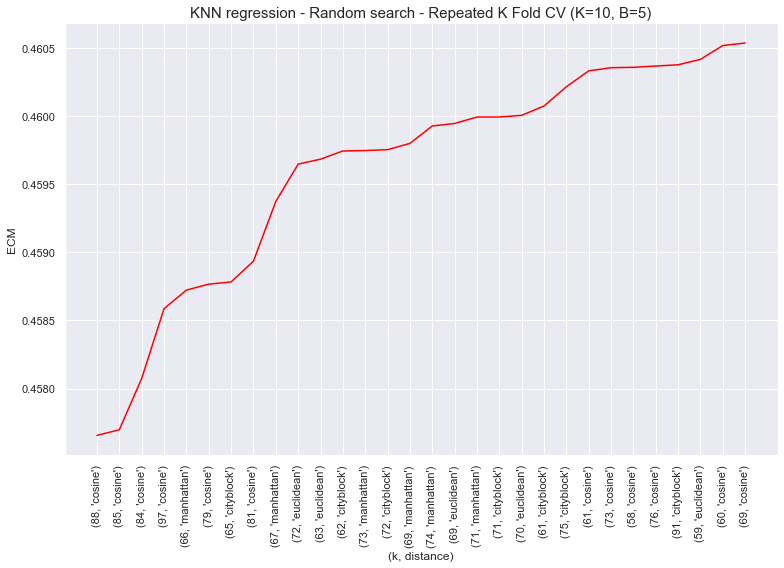

In [218]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="ECM", x='(k, distance)', data=RandomSearch_5_Repeated_10Fold_regression.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated K Fold CV (K=10, B=5)", fontsize=15)

plt.tight_layout()

fig.savefig('p6.jpg', format='jpg', dpi=600)

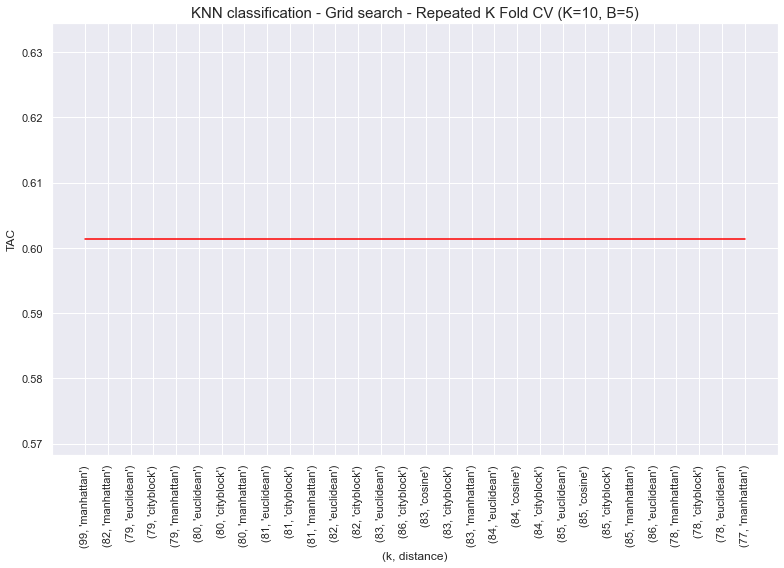

In [217]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="TAC", x='(k, distance)', data=GridSearch_5_Repeated_10Fold_classification.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated K Fold CV (K=10, B=5)", fontsize=15)

plt.tight_layout()

fig.savefig('p7.jpg', format='jpg', dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))

p = sns.lineplot(y="TAC", x='(k, distance)', data=GridSearch_5_Repeated_10Fold_classification.iloc[0:30, :], color='red')

plt.setp(p.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated K Fold CV (K=10, B=5)", fontsize=15)

plt.tight_layout()

fig.savefig('p7.jpg', format='jpg', dpi=600)

In [51]:
GridSearch_init = GridSearch(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM',  B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [52]:
GridSearch_init.fit()

In [53]:
GridSearch_init.get_df_grid_search()

,"(k, distance)",ECM
57,"(15, cosine)",2.064764e+12
61,"(16, cosine)",2.067621e+12
65,"(17, cosine)",2.079897e+12
53,"(14, cosine)",2.086479e+12
58,"(15, cityblock)",2.088501e+12
...,...,...
395,"(99, manhattan)",3.470547e+12
392,"(99, euclidean)",3.471920e+12
1,"(1, cosine)",3.646170e+12
2,"(1, cityblock)",3.677001e+12


In [ ]:
GridSearch_init = GridSearch(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='K_Fold_CV', metric='ECM',  B=10, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
GridSearch_init.fit()

In [ ]:
GridSearch_init.get_df_grid_search()

In [ ]:
GridSearch_init = GridSearch(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM',  B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_1 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
def Grid_search(Data, Search_Space, response, model, validation, metric, B, k, K, random_seed_2, random_search, random_seed_1, random_samples):

   Grid_Search_Metric_list = []

   hyperparameter_combinations = list( itertools.product(Search_Space[0], Search_Space[1]) )

   if random_search == True : 
      
      hyperparameter_combinations = resample(hyperparameter_combinations, n_samples=random_samples, replace=False, random_state=random_seed_1)
   
   else : 
      
      pass


   if model == 'knn_regression' :

      if validation == 'repeated_random_simple_validation' :

         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0] ,  metric=h[1]) 

            # Applying a validation algorithm on the model 
             
            RepeatedRandomSimpleValidation_init = RepeatedRandomSimpleValidation(B=B, k=k, metric=metric, model=knn_regression_init, random_seed=random_seed_2)

            RepeatedRandomSimpleValidation_init.fit(D=Data, response_name=response ) 

            Grid_Search_Metric_list.append( RepeatedRandomSimpleValidation_init.compute_metric()  )


      #####################################################################################################################################   
          
      if validation == 'K_Fold_CV' :
            
         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0] ,  metric=h[1]) 

            # Applying a validation algorithm on the model 
 

            KFoldCV_init =  KFoldCV(D=Data, K=K, response_name=response, random_seed=random_seed_2, metric=metric, model=knn_regression_init) 

            KFoldCV_init.fit( ) 

            Grid_Search_Metric_list.append( KFoldCV_init.get_metric() )            

      #####################################################################################################################################
          
      if validation == 'repeated_K_Fold_CV' :
            
         for h in hyperparameter_combinations :
            
            # Setting the hyperparameters of the model

            knn_regression_init = sklearn.neighbors.KNeighborsRegressor(n_neighbors=h[0] ,  metric=h[1]) 

            # Applying a validation algorithm on the model 

            RepeatedKFoldCV_init = RepeatedKFoldCV(B=B, K=K, random_seed=random_seed_2, metric=metric, model=knn_regression_init)

            RepeatedKFoldCV_init.fit(D=Data, response_name=response ) 

            Grid_Search_Metric_list.append( RepeatedKFoldCV_init.get_metric() )


#####################################################################################################################################################

   df = pd.DataFrame({'(k , distance)': hyperparameter_combinations, metric: Grid_Search_Metric_list})

   if metric == 'ECM' :

      df = df.sort_values(by=metric, ascending=True)

   elif metric == 'TAC' :

      df = df.sort_values(by=metric, ascending=False)


   return df

In [ ]:
Grid_search_1 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 56.8seg

In [ ]:
Grid_search_1

,"(k , distance)",ECM
57,"(15, cosine)",2.064764e+12
61,"(16, cosine)",2.067621e+12
65,"(17, cosine)",2.079897e+12
53,"(14, cosine)",2.086479e+12
58,"(15, cityblock)",2.088501e+12
...,...,...
395,"(99, manhattan)",3.470547e+12
392,"(99, euclidean)",3.471920e+12
1,"(1, cosine)",3.646170e+12
2,"(1, cityblock)",3.677001e+12


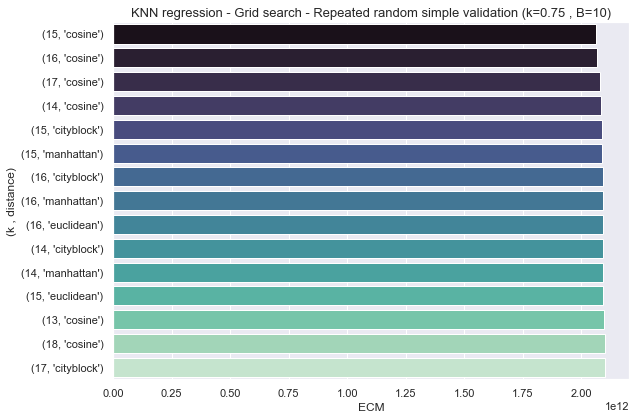

In [ ]:
fig, ax = plt.subplots()

p1 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_1.iloc[0:15 , :], palette='mako')

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=10)", fontsize=13)

plt.tight_layout()

fig.savefig('p1.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_1

,"(k , distance)",ECM
57,"(15, cosine)",2.064764e+12
61,"(16, cosine)",2.067621e+12
65,"(17, cosine)",2.079897e+12
53,"(14, cosine)",2.086479e+12
58,"(15, cityblock)",2.088501e+12
...,...,...
395,"(99, manhattan)",3.470547e+12
392,"(99, euclidean)",3.471920e+12
1,"(1, cosine)",3.646170e+12
2,"(1, cityblock)",3.677001e+12


In [ ]:
Grid_search_1.dtypes

(k , distance)     object
ECM               float64
dtype: object

In [ ]:
Grid_search_1['(k , distance)'] = Grid_search_1['(k , distance)'].astype('str') 

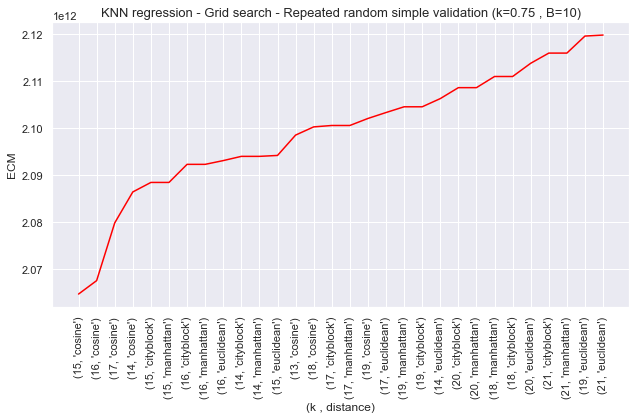

In [ ]:
fig, ax = plt.subplots()

p1 = sns.lineplot(y="ECM", x ='(k , distance)' , data=Grid_search_1.iloc[0:30 , :], color='red')

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=10)", fontsize=13)

plt.setp(p1.get_xticklabels(), rotation=90)

plt.tight_layout()

fig.savefig('p1_new.jpg', format='jpg', dpi=1200)

plt.show()

In [ ]:
Grid_search_1_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=10, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_1_2

,"(k , distance)",TAC
210,"(53, cityblock)",0.595168
211,"(53, manhattan)",0.595168
301,"(76, cosine)",0.594958
293,"(74, cosine)",0.594958
297,"(75, cosine)",0.594748
...,...,...
12,"(4, euclidean)",0.483403
5,"(2, cosine)",0.429622
7,"(2, manhattan)",0.411555
6,"(2, cityblock)",0.411555


In [ ]:
Grid_search_1_2['(k , distance)'] = Grid_search_1_2['(k , distance)'].astype('str') 

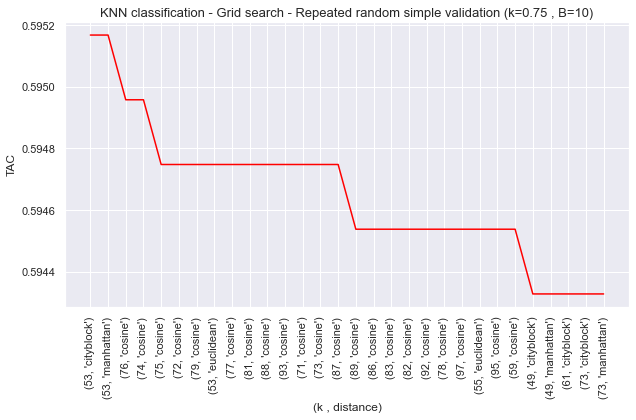

In [ ]:
fig, ax = plt.subplots()

p2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_1_2.iloc[0:30 , :], color='red')

plt.setp(p2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=10)", fontsize=13)

plt.tight_layout()

fig.savefig('p1_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 1.57seg

In [ ]:
Grid_search_2['(k , distance)'] = Grid_search_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_2

,"(k , distance)",ECM
61,"(16, cosine)",2.079239e+12
57,"(15, cosine)",2.084669e+12
65,"(17, cosine)",2.090697e+12
53,"(14, cosine)",2.108925e+12
73,"(19, cosine)",2.109291e+12
...,...,...
391,"(98, manhattan)",3.700114e+12
388,"(98, euclidean)",3.703232e+12
394,"(99, cityblock)",3.710922e+12
395,"(99, manhattan)",3.710922e+12


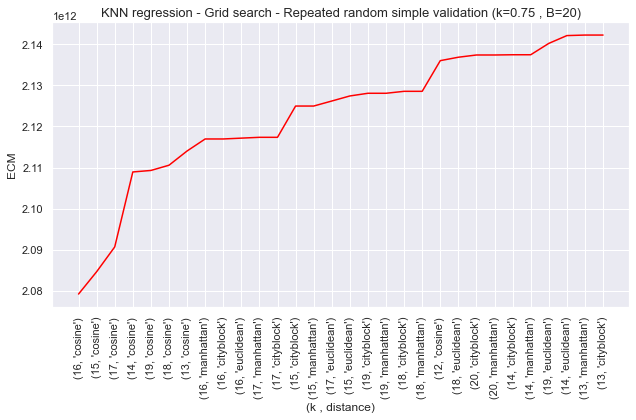

In [ ]:
fig, ax = plt.subplots()

p3 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_2.iloc[0:30 , :], color='red')

plt.setp(p3.get_xticklabels(), rotation=90)

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_2_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_2_2['(k , distance)'] = Grid_search_2_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_2_2

,"(k , distance)",TAC
369,"(93, cosine)",0.597689
349,"(88, cosine)",0.597689
321,"(81, cosine)",0.597689
345,"(87, cosine)",0.597689
325,"(82, cosine)",0.597584
...,...,...
12,"(4, euclidean)",0.478782
5,"(2, cosine)",0.431092
7,"(2, manhattan)",0.416071
6,"(2, cityblock)",0.416071


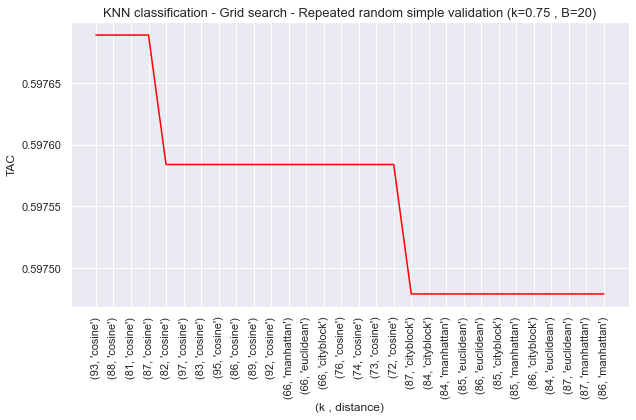

In [ ]:
fig, ax = plt.subplots()

p4 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_2_2.iloc[0:30 , :], color='red')

plt.setp(p4.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p2_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_3 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

Time: 5.3min

In [ ]:
Grid_search_3['(k , distance)'] = Grid_search_3['(k , distance)'].astype('str') 

In [ ]:
Grid_search_3

,"(k , distance)",ECM
61,"(16, cosine)",2.079239e+12
57,"(15, cosine)",2.084669e+12
65,"(17, cosine)",2.090697e+12
53,"(14, cosine)",2.108925e+12
73,"(19, cosine)",2.109291e+12
...,...,...
791,"(198, manhattan)",4.670408e+12
788,"(198, euclidean)",4.672717e+12
794,"(199, cityblock)",4.676174e+12
795,"(199, manhattan)",4.676174e+12


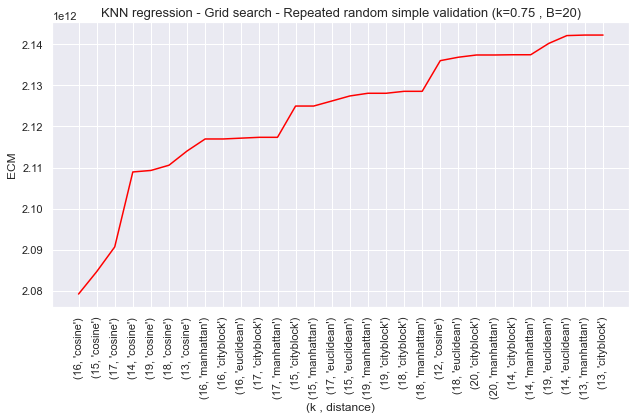

In [ ]:
fig, ax = plt.subplots()

p5 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_3.iloc[0:30, :], color='red')

plt.setp(p5.get_xticklabels(), rotation=90)

plt.title("KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p3_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_3_2 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_3_2['(k , distance)'] = Grid_search_3_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_3_2

,"(k , distance)",TAC
349,"(88, cosine)",0.597689
369,"(93, cosine)",0.597689
321,"(81, cosine)",0.597689
345,"(87, cosine)",0.597689
301,"(76, cosine)",0.597584
...,...,...
12,"(4, euclidean)",0.478782
5,"(2, cosine)",0.431092
7,"(2, manhattan)",0.416071
6,"(2, cityblock)",0.416071


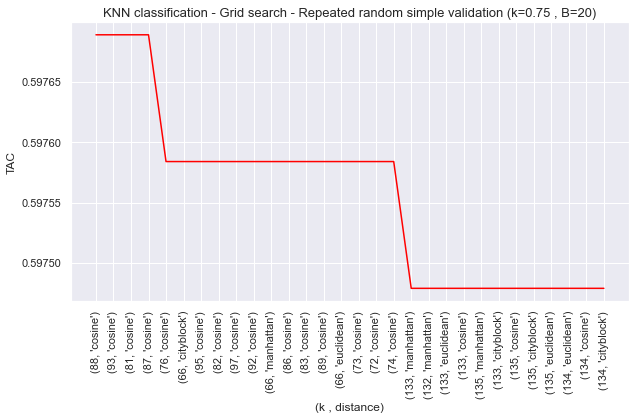

In [ ]:
fig, ax = plt.subplots()

p5_2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_3_2.iloc[0:30 , :], color='red')

plt.setp(p5_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p3_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_4 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_random_simple_validation', metric='ECM', B=20, k=0.75, K='no', random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_4['(k , distance)'] = Grid_search_4['(k , distance)'].astype('str') 

Time: 1.2min

In [ ]:
Grid_search_4

,"(k , distance)",ECM
23,"(15, cosine)",2.084669e+12
190,"(15, manhattan)",2.124952e+12
165,"(17, euclidean)",2.126173e+12
47,"(19, cityblock)",2.128057e+12
68,"(19, manhattan)",2.128057e+12
...,...,...
128,"(196, cityblock)",4.657349e+12
199,"(196, euclidean)",4.659289e+12
17,"(198, cityblock)",4.670408e+12
142,"(198, manhattan)",4.670408e+12


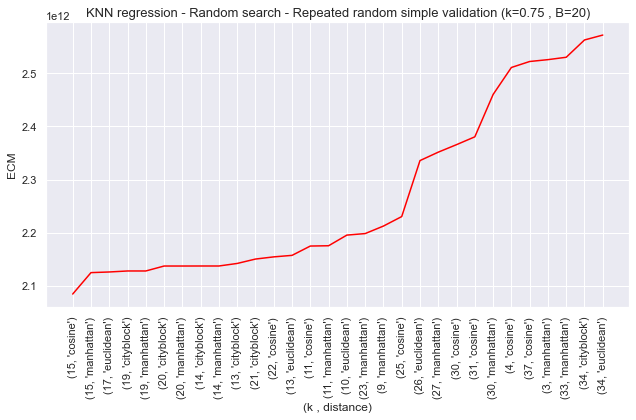

In [ ]:
fig, ax = plt.subplots()

p6 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_4.iloc[0:30 , :], color='red')

plt.setp(p6.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p4_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_4_2 = Grid_search(Data=Data, Search_Space=[range(1,200) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_random_simple_validation', metric='TAC', B=20, k=0.75, K='no', random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_4_2['(k , distance)'] = Grid_search_4_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_4_2

,"(k , distance)",TAC
125,"(93, cosine)",0.597689
167,"(87, cosine)",0.597689
73,"(66, euclidean)",0.597584
175,"(83, cosine)",0.597584
119,"(66, manhattan)",0.597584
...,...,...
160,"(3, cosine)",0.507983
91,"(4, cosine)",0.504727
78,"(3, manhattan)",0.488866
118,"(2, cosine)",0.431092


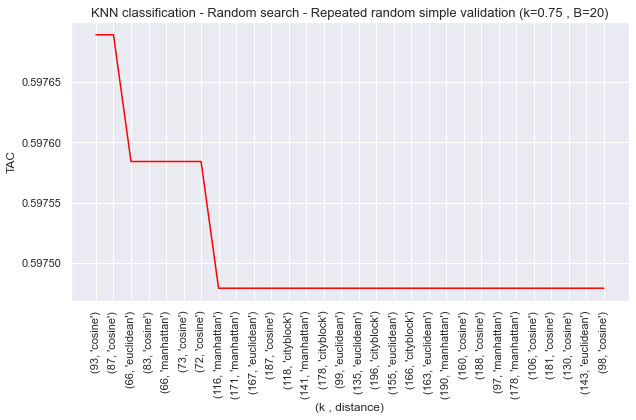

In [ ]:
fig, ax = plt.subplots()

p6_2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_4_2.iloc[0:30 , :], color='red')

plt.setp(p6_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - Repeated random simple validation (k=0.75 , B=20)", fontsize=13)

plt.tight_layout()

fig.savefig('p4_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_5 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=5, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_5['(k , distance)'] = Grid_search_5['(k , distance)'].astype('str') 

Time: 4.37 min

In [ ]:
Grid_search_5

,"(k , distance)",ECM
69,"(18, cosine)",2.213103e+12
73,"(19, cosine)",2.213636e+12
57,"(15, cosine)",2.215151e+12
61,"(16, cosine)",2.221992e+12
65,"(17, cosine)",2.222929e+12
...,...,...
391,"(98, manhattan)",4.068432e+12
388,"(98, euclidean)",4.072752e+12
394,"(99, cityblock)",4.087051e+12
395,"(99, manhattan)",4.087051e+12


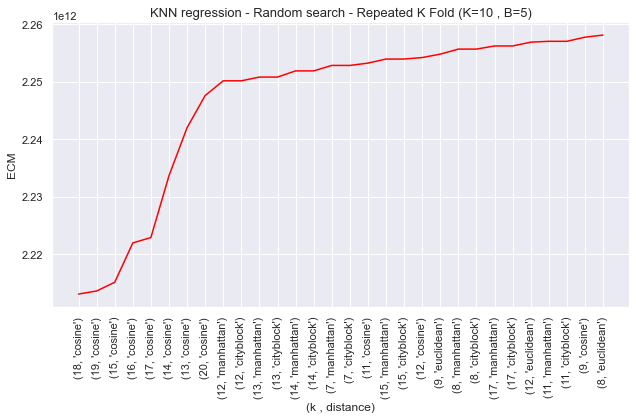

In [ ]:
fig, ax = plt.subplots()

p7 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_5.iloc[0:30, :], color='red')

plt.setp(p7.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p5_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_5_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_K_Fold_CV', metric='TAC', B=5, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_5_2['(k , distance)'] = Grid_search_5_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_5_2

,"(k , distance)",TAC
395,"(99, manhattan)",0.601331
322,"(81, cityblock)",0.601331
324,"(82, euclidean)",0.601331
326,"(82, cityblock)",0.601331
327,"(82, manhattan)",0.601331
...,...,...
1,"(1, cosine)",0.450732
5,"(2, cosine)",0.383782
6,"(2, cityblock)",0.375330
7,"(2, manhattan)",0.375330


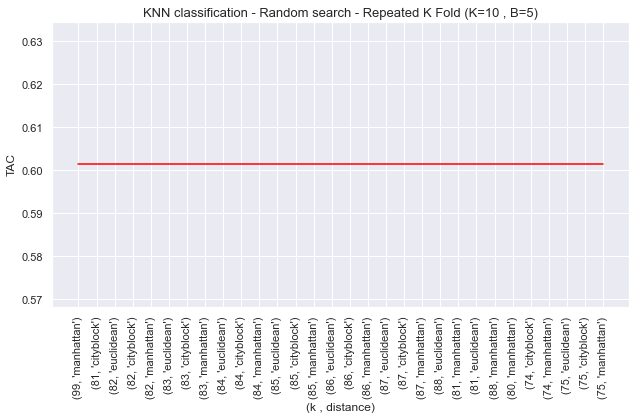

In [ ]:
fig, ax = plt.subplots()

p7_2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_5_2.iloc[0:30, :], color='red')

plt.setp(p7_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p5_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_6 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=15, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_6['(k , distance)'] = Grid_search_6['(k , distance)'].astype('str') 

Time: 14.35min

In [ ]:
Grid_search_6

,"(k , distance)",ECM
65,"(17, cosine)",2.212144e+12
69,"(18, cosine)",2.214874e+12
61,"(16, cosine)",2.215972e+12
73,"(19, cosine)",2.220315e+12
57,"(15, cosine)",2.226790e+12
...,...,...
390,"(98, cityblock)",4.082009e+12
388,"(98, euclidean)",4.086456e+12
394,"(99, cityblock)",4.101063e+12
395,"(99, manhattan)",4.101063e+12


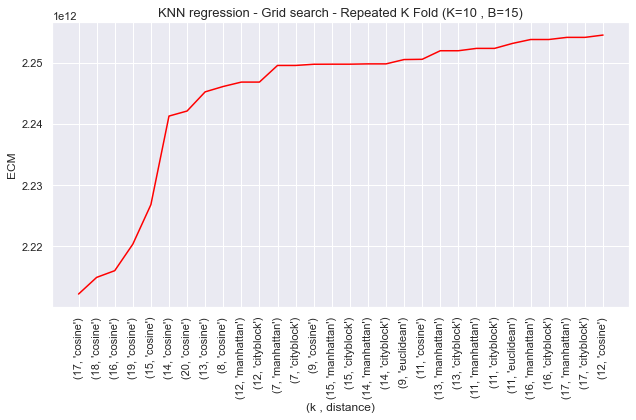

In [ ]:
fig, ax = plt.subplots()

p8 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_6.iloc[0:30, :], color='red')

plt.setp(p8.get_xticklabels(), rotation=90)

plt.title("KNN regression - Grid search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p6_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_6_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_K_Fold_CV', metric='TAC', B=15, k='no', K=10, random_search=False, random_samples=150, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_6_2['(k , distance)'] = Grid_search_6_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_6_2

,"(k , distance)",TAC
395,"(99, manhattan)",0.601570
322,"(81, cityblock)",0.601570
324,"(82, euclidean)",0.601570
326,"(82, cityblock)",0.601570
327,"(82, manhattan)",0.601570
...,...,...
1,"(1, cosine)",0.451868
5,"(2, cosine)",0.383867
7,"(2, manhattan)",0.375072
6,"(2, cityblock)",0.375072


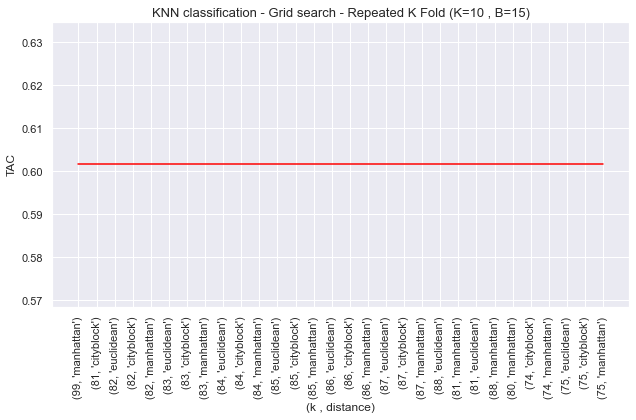

In [ ]:
fig, ax = plt.subplots()

p8_2 = sns.lineplot(y="TAC", x='(k , distance)', data=Grid_search_6_2.iloc[0:30, :], color='red')

plt.setp(p8_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Grid search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p6_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_7 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=15, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_7['(k , distance)'] = Grid_search_7['(k , distance)'].astype('str') 

Time: 7.29 mins

In [ ]:
Grid_search_7

,"(k , distance)",ECM
164,"(16, cosine)",2.215972e+12
138,"(14, cosine)",2.241301e+12
196,"(13, cosine)",2.245269e+12
125,"(8, cosine)",2.246148e+12
50,"(7, cityblock)",2.249594e+12
...,...,...
36,"(97, euclidean)",4.069186e+12
53,"(98, manhattan)",4.082009e+12
134,"(99, cityblock)",4.101063e+12
130,"(99, manhattan)",4.101063e+12


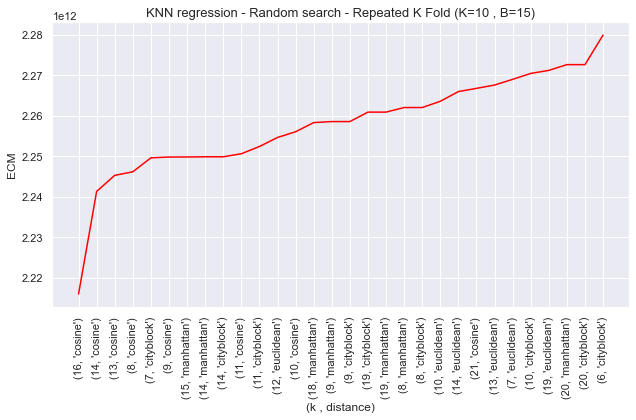

In [ ]:
fig, ax = plt.subplots()

p9 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_7.iloc[0:30 , :], color='red')

plt.setp(p9.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p7_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_7_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_K_Fold_CV', metric='TAC', B=15, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_7_2['(k , distance)'] = Grid_search_7_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_7_2

,"(k , distance)",TAC
199,"(83, euclidean)",0.601570
160,"(84, euclidean)",0.601570
152,"(91, manhattan)",0.601570
36,"(97, euclidean)",0.601570
37,"(83, cityblock)",0.601570
...,...,...
94,"(1, euclidean)",0.451919
121,"(2, cosine)",0.383867
82,"(2, cityblock)",0.375072
182,"(2, manhattan)",0.375072


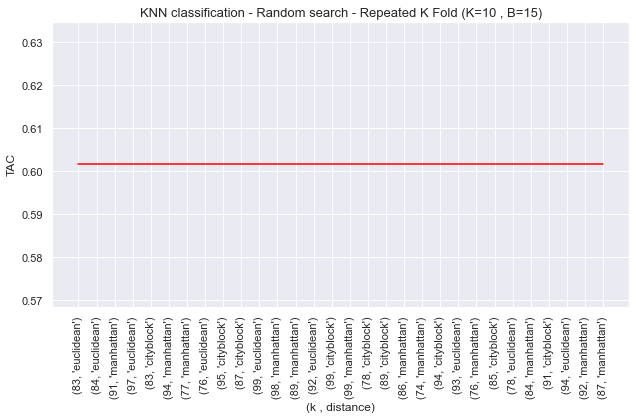

In [ ]:
fig, ax = plt.subplots()

p9_2 = sns.lineplot(y="TAC", x='(k , distance)', data=Grid_search_7_2.iloc[0:30, :], color='red')

plt.setp(p9_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - Repeated K Fold (K=10 , B=15)", fontsize=13)

plt.tight_layout()

fig.savefig('p7_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_8 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=5, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_8['(k , distance)'] = Grid_search_8['(k , distance)'].astype('str') 

Time: 2.16min

In [ ]:
Grid_search_8

,"(k , distance)",ECM
164,"(16, cosine)",2.221992e+12
138,"(14, cosine)",2.233684e+12
196,"(13, cosine)",2.242026e+12
106,"(14, manhattan)",2.251908e+12
6,"(14, cityblock)",2.251908e+12
...,...,...
36,"(97, euclidean)",4.056875e+12
53,"(98, manhattan)",4.068432e+12
134,"(99, cityblock)",4.087051e+12
130,"(99, manhattan)",4.087051e+12


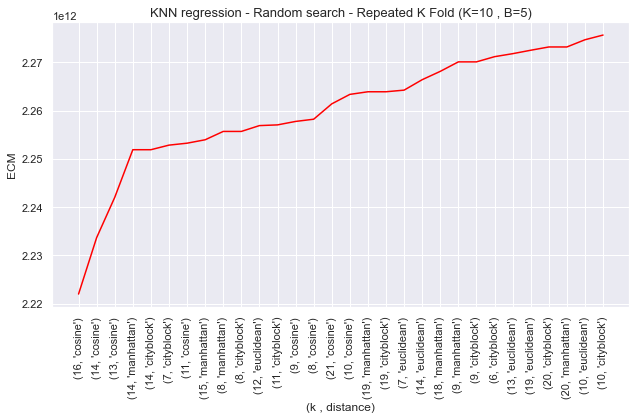

In [ ]:
fig, ax = plt.subplots()

p10 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_8.iloc[0:30, :], color='red')

plt.setp(p10.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p8_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_8_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_K_Fold_CV', metric='TAC', B=5, k='no', K=10, random_search=True, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_8_2['(k , distance)'] = Grid_search_8_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_8_2

,"(k , distance)",TAC
199,"(83, euclidean)",0.601331
160,"(84, euclidean)",0.601331
155,"(96, cosine)",0.601331
36,"(97, euclidean)",0.601331
37,"(83, cityblock)",0.601331
...,...,...
94,"(1, euclidean)",0.451380
121,"(2, cosine)",0.383782
182,"(2, manhattan)",0.375330
82,"(2, cityblock)",0.375330


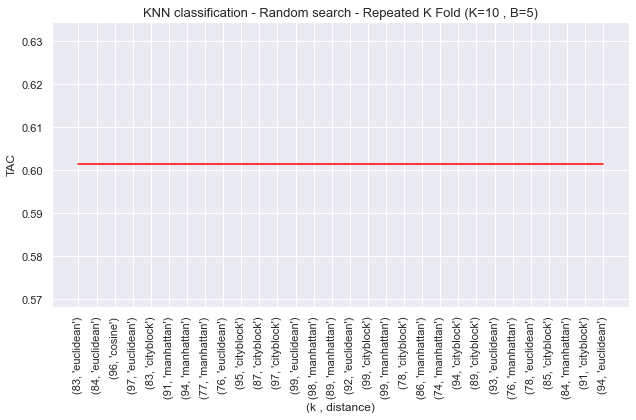

In [ ]:
fig, ax = plt.subplots()

p10_2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_8_2.iloc[0:30 , :], color='red')

plt.setp(p10_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - Repeated K Fold (K=10 , B=5)", fontsize=13)

plt.tight_layout()

fig.savefig('p8_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_9 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='price', model='knn_regression', validation='repeated_K_Fold_CV', metric='ECM', B=1, k='no', K=10, random_search=False, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_9['(k , distance)'] = Grid_search_9['(k , distance)'].astype('str') 

In [ ]:
Grid_search_9

,"(k , distance)",ECM
30,"(8, cityblock)",2.149765e+12
31,"(8, manhattan)",2.149765e+12
28,"(8, euclidean)",2.167357e+12
69,"(18, cosine)",2.172008e+12
33,"(9, cosine)",2.179763e+12
...,...,...
391,"(98, manhattan)",4.028750e+12
388,"(98, euclidean)",4.032013e+12
394,"(99, cityblock)",4.048032e+12
395,"(99, manhattan)",4.048032e+12


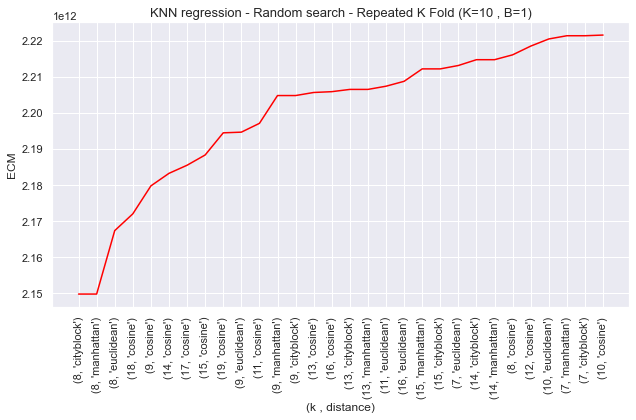

In [ ]:
fig, ax = plt.subplots()

p11 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_9.iloc[0:30 , :], color='red')

plt.setp(p11.get_xticklabels(), rotation=90)

plt.title("KNN regression - Random search - Repeated K Fold (K=10 , B=1)", fontsize=13)

plt.tight_layout()

fig.savefig('p9_new.jpg', format='jpg', dpi=1200)

In [ ]:
Grid_search_9_2 = Grid_search(Data=Data, Search_Space=[range(1,100) , ['euclidean','cosine','cityblock','manhattan']], response='quality_recode', model='knn_classification', validation='repeated_K_Fold_CV', metric='TAC', B=1, k='no', K=10, random_search=False, random_samples=200, random_seed_1=123, random_seed_2=123)

In [ ]:
Grid_search_9_2['(k , distance)'] = Grid_search_9_2['(k , distance)'].astype('str') 

In [ ]:
Grid_search_9_2

,"(k , distance)",TAC
395,"(99, manhattan)",0.601334
327,"(82, manhattan)",0.601334
312,"(79, euclidean)",0.601334
314,"(79, cityblock)",0.601334
315,"(79, manhattan)",0.601334
...,...,...
1,"(1, cosine)",0.450322
5,"(2, cosine)",0.381866
7,"(2, manhattan)",0.375512
6,"(2, cityblock)",0.375512


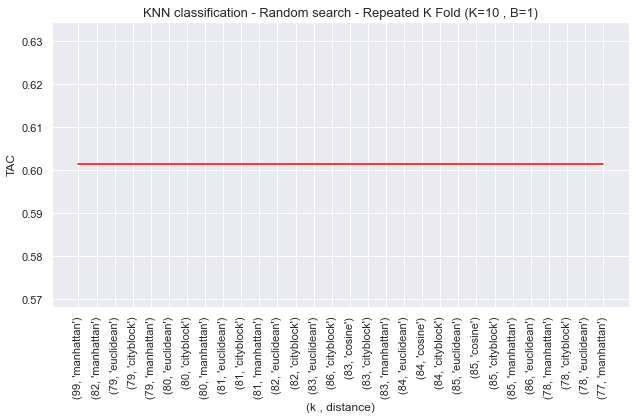

In [ ]:
fig, ax = plt.subplots()

p11_2 = sns.lineplot(y="TAC", x='(k , distance)' , data=Grid_search_9_2.iloc[0:30, :], color='red')

plt.setp(p11_2.get_xticklabels(), rotation=90)

plt.title("KNN classification - Random search - Repeated K Fold (K=10 , B=1)", fontsize=13)

plt.tight_layout()

fig.savefig('p9_2_new.jpg', format='jpg', dpi=1200)

In [ ]:
sns.set(font_scale=2)

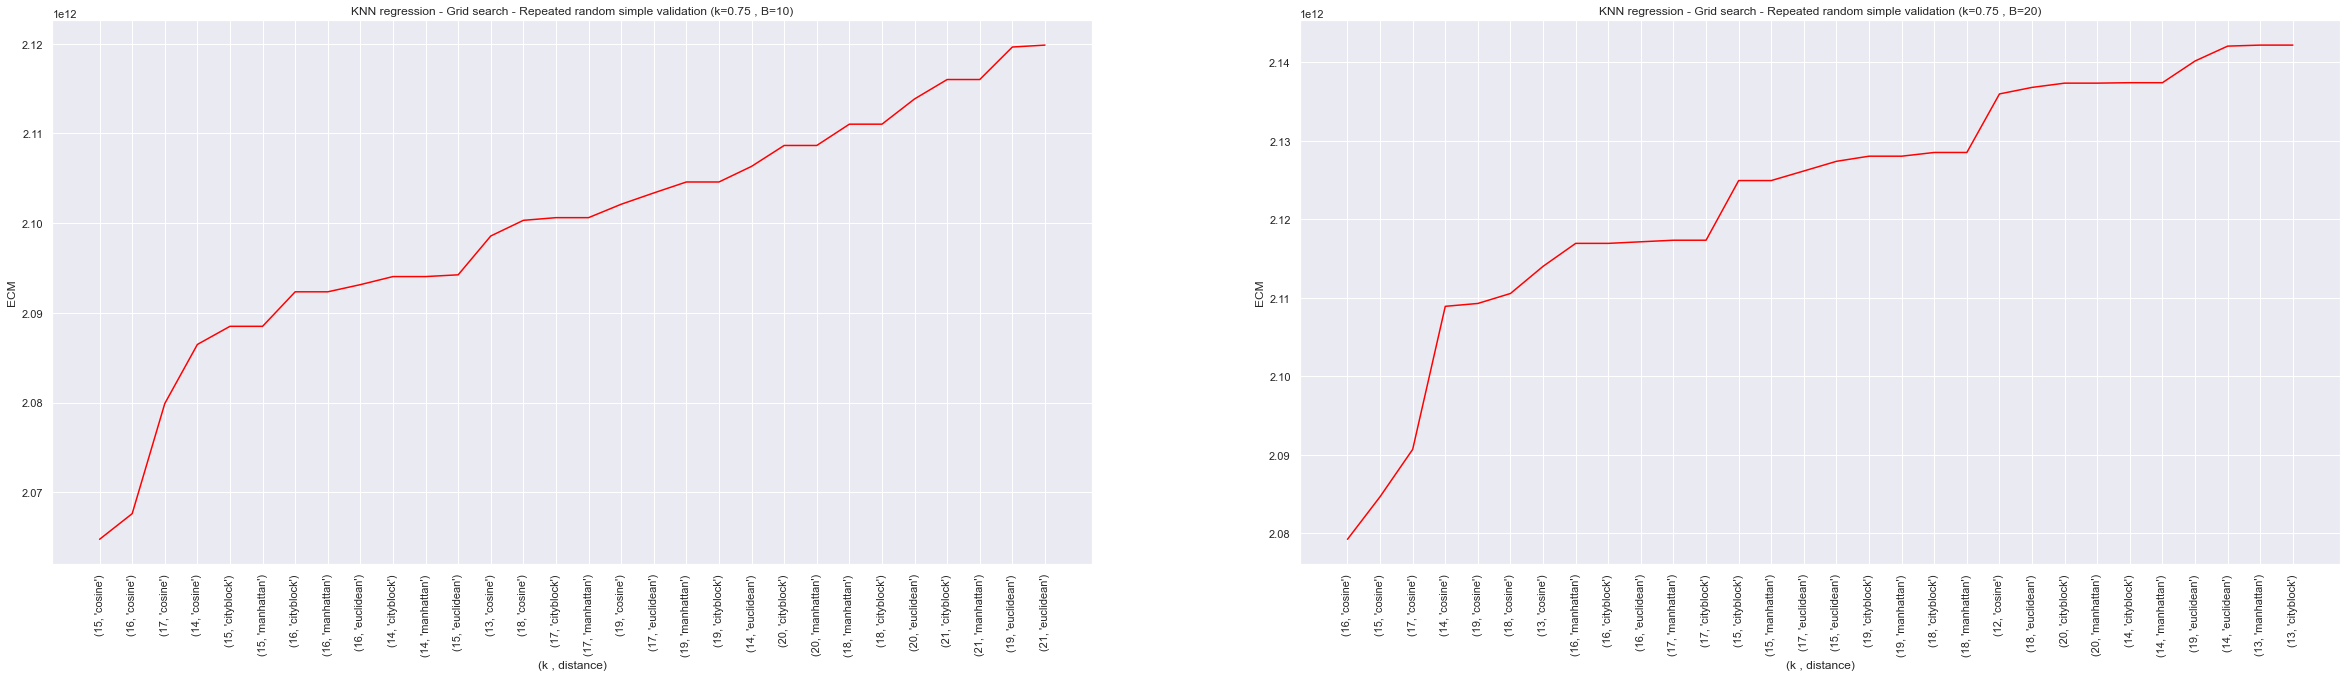

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p1 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_1.iloc[0:30 , :], color='red', ax=axs[0])

plt.setp(p1.get_xticklabels(), rotation=90)
p1.title.set_text('KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=10)')

p3 = sns.lineplot(y="ECM", x='(k , distance)' , data=Grid_search_2.iloc[0:30 , :], color='red', ax=axs[1])

plt.setp(p3.get_xticklabels(), rotation=90)
p3.title.set_text('KNN regression - Grid search - Repeated random simple validation (k=0.75 , B=20)')

fig.savefig('p1big_1.jpg', format='jpg', dpi=750)

plt.tight_layout()

plt.show()

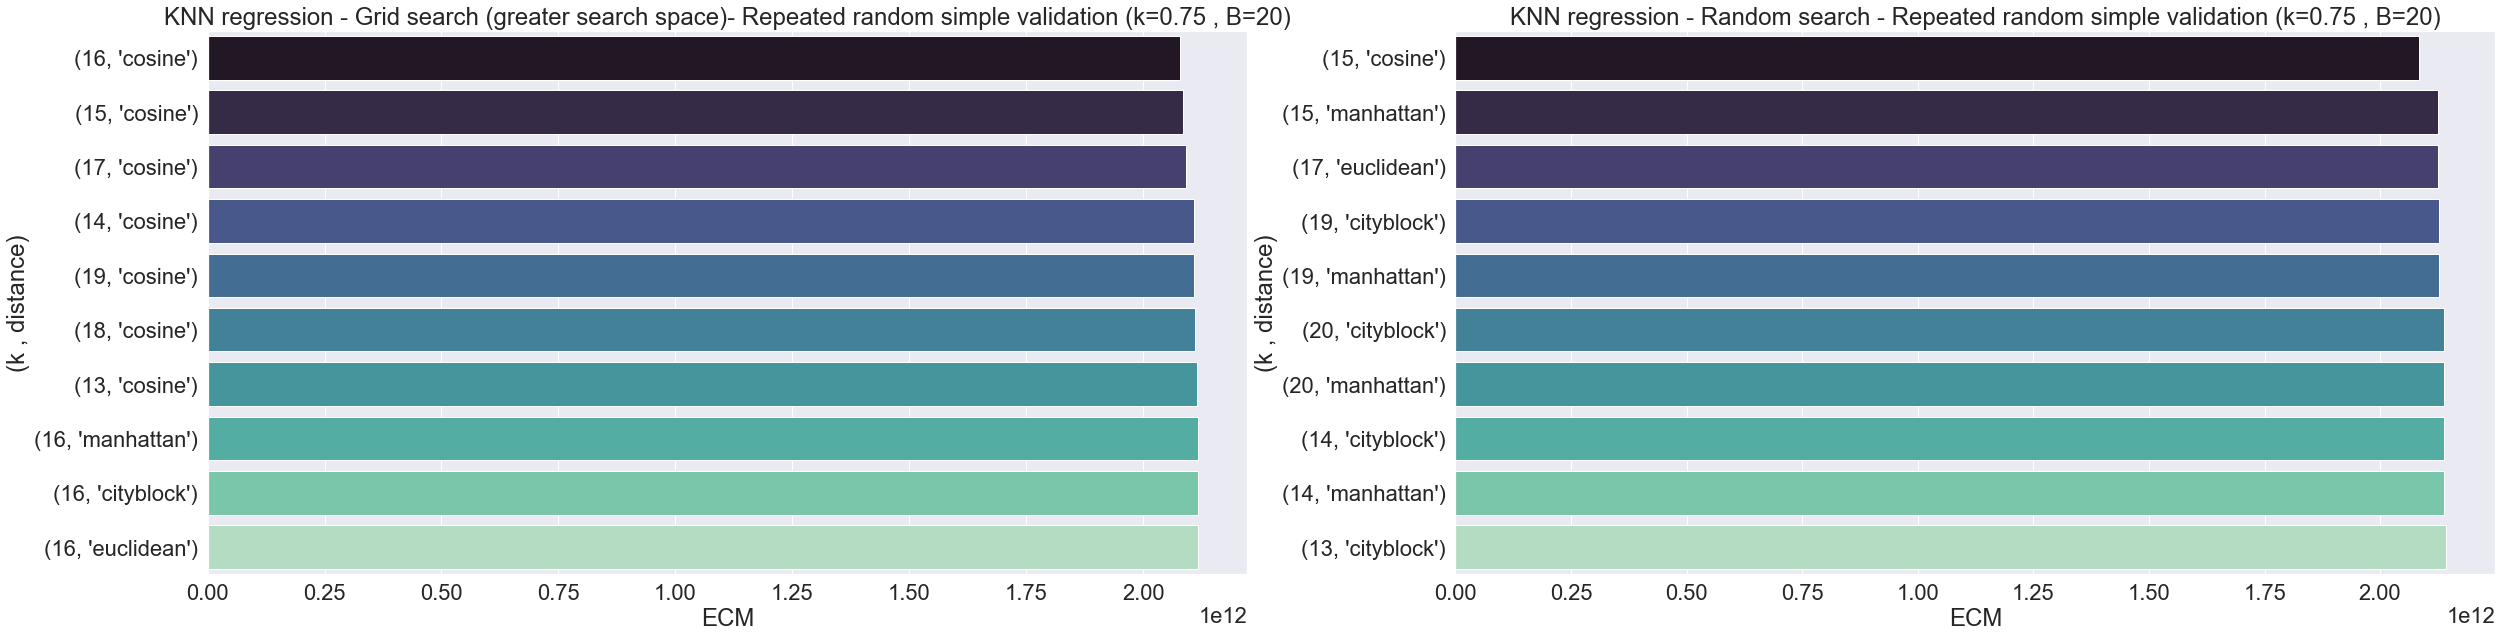

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p5 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_3.iloc[0:10 , :], palette='mako', ax=axs[0])

p5.title.set_text('KNN regression - Grid search (greater search space)- Repeated random simple validation (k=0.75 , B=20)')

p6 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_4.iloc[0:10 , :], palette='mako', ax=axs[1])

p6.title.set_text('KNN regression - Random search - Repeated random simple validation (k=0.75 , B=20)')

fig.savefig('p1big_2.jpg', format='jpg', dpi=750)

plt.show()

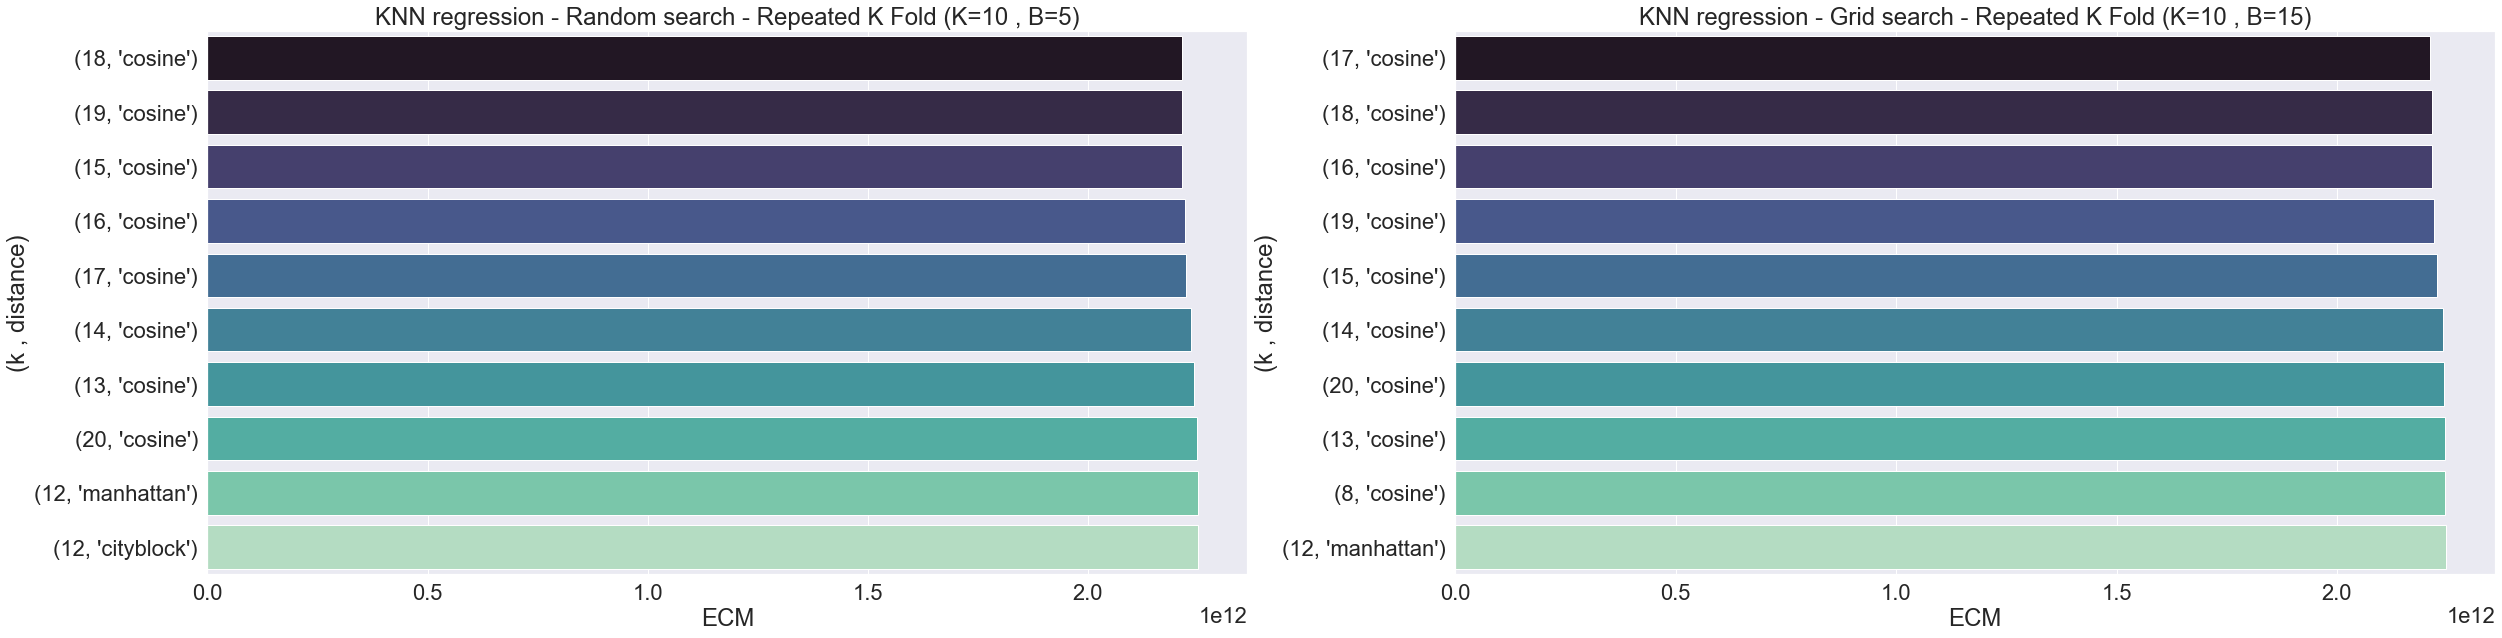

In [ ]:
fig, axs =  plt.subplots(1, 2, figsize=(41, 10))

p7 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_5.iloc[0:10 , :], palette='mako', ax=axs[0])

p7.title.set_text('KNN regression - Random search - Repeated K Fold (K=10 , B=5)')

p8 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_6.iloc[0:10 , :], palette='mako', ax=axs[1])

p8.title.set_text('KNN regression - Grid search - Repeated K Fold (K=10 , B=15)')

fig.savefig('p1big_2_1.jpg', format='jpg', dpi=750)

plt.show()

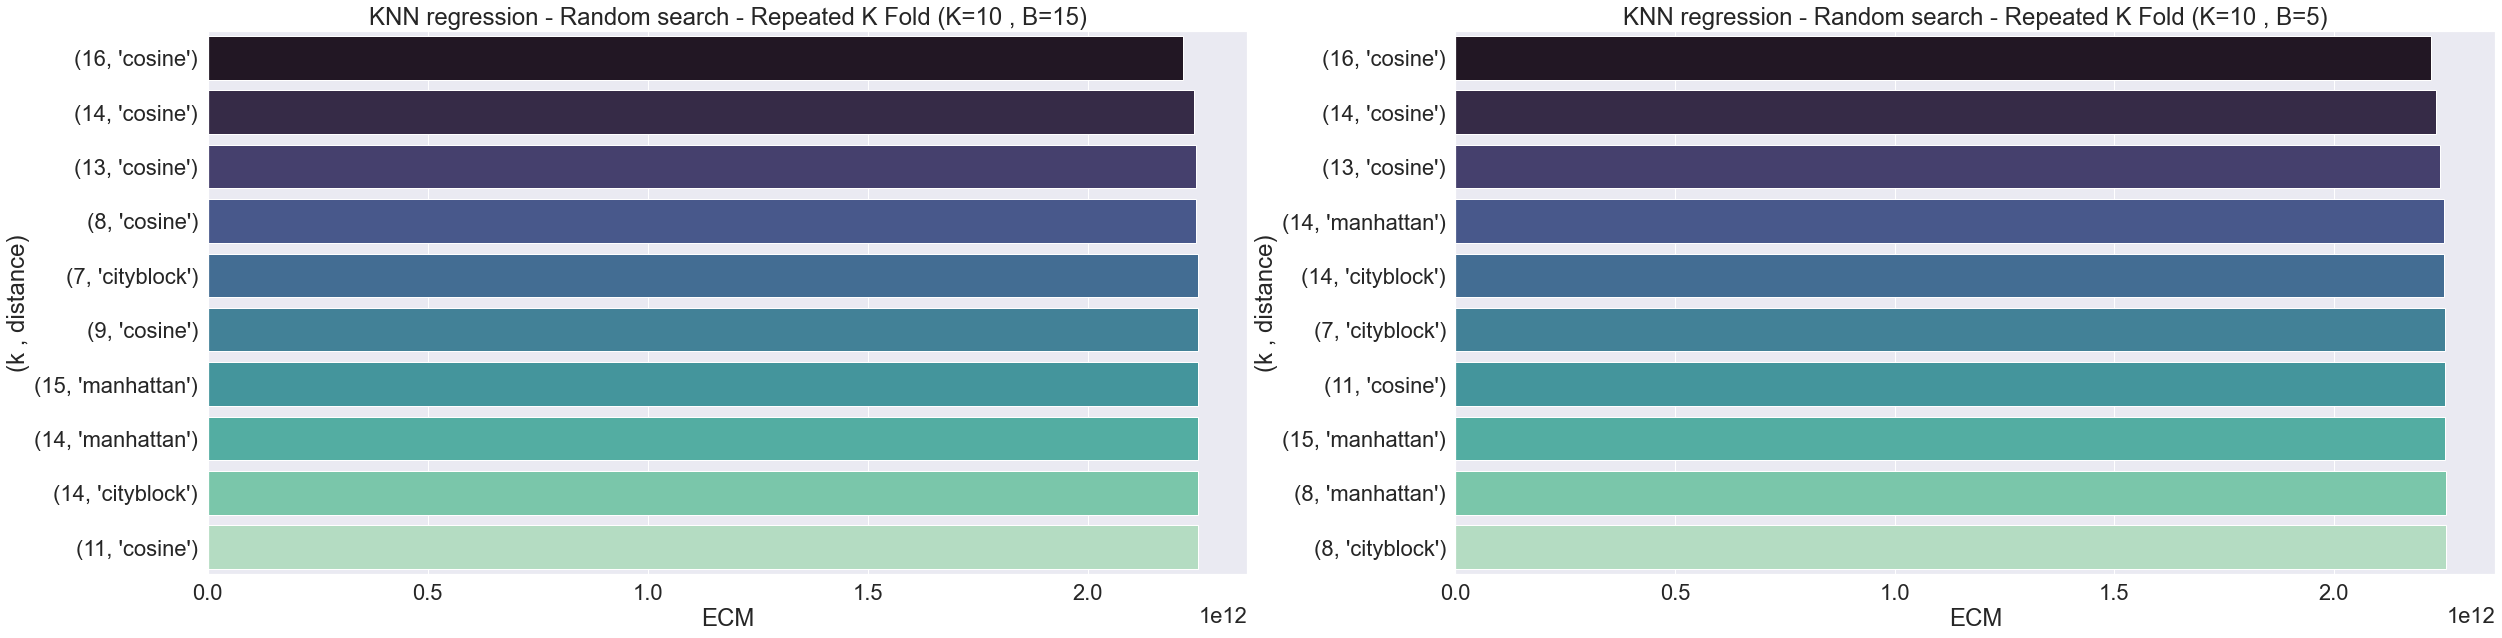

In [ ]:
fig, axs =  plt.subplots(1, 2, figsize=(41, 10))

p9 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_7.iloc[0:10 , :], palette='mako', ax=axs[0])

p9.title.set_text('KNN regression - Random search - Repeated K Fold (K=10 , B=15)')

p10 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_8.iloc[0:10 , :], palette='mako', ax=axs[1])

p10.title.set_text('KNN regression - Random search - Repeated K Fold (K=10 , B=5)')

fig.savefig('p1big_2_2.jpg', format='jpg', dpi=750)

plt.show()

In [ ]:
sns.set(font_scale=1)

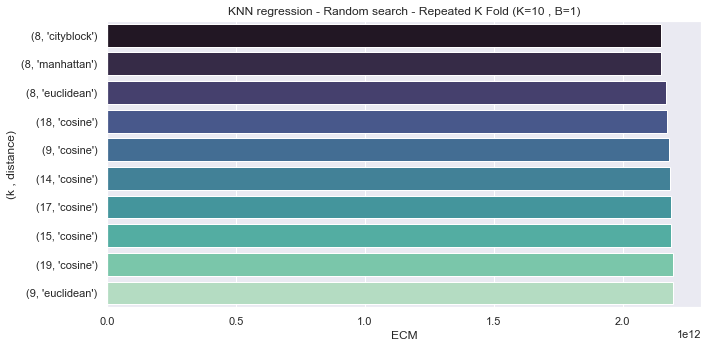

In [ ]:
fig, axs =  plt.subplots(figsize=(10, 5))

p11 = sns.barplot(x="ECM", y ='(k , distance)' , data=Grid_search_9.iloc[0:10 , :], palette='mako')

p11.title.set_text('KNN regression - Random search - Repeated K Fold (K=10 , B=1)')

plt.tight_layout()

fig.savefig('p1big_2_3.jpg', format='jpg', dpi=750)

plt.show()

In [ ]:
sns.set(font_scale=2)

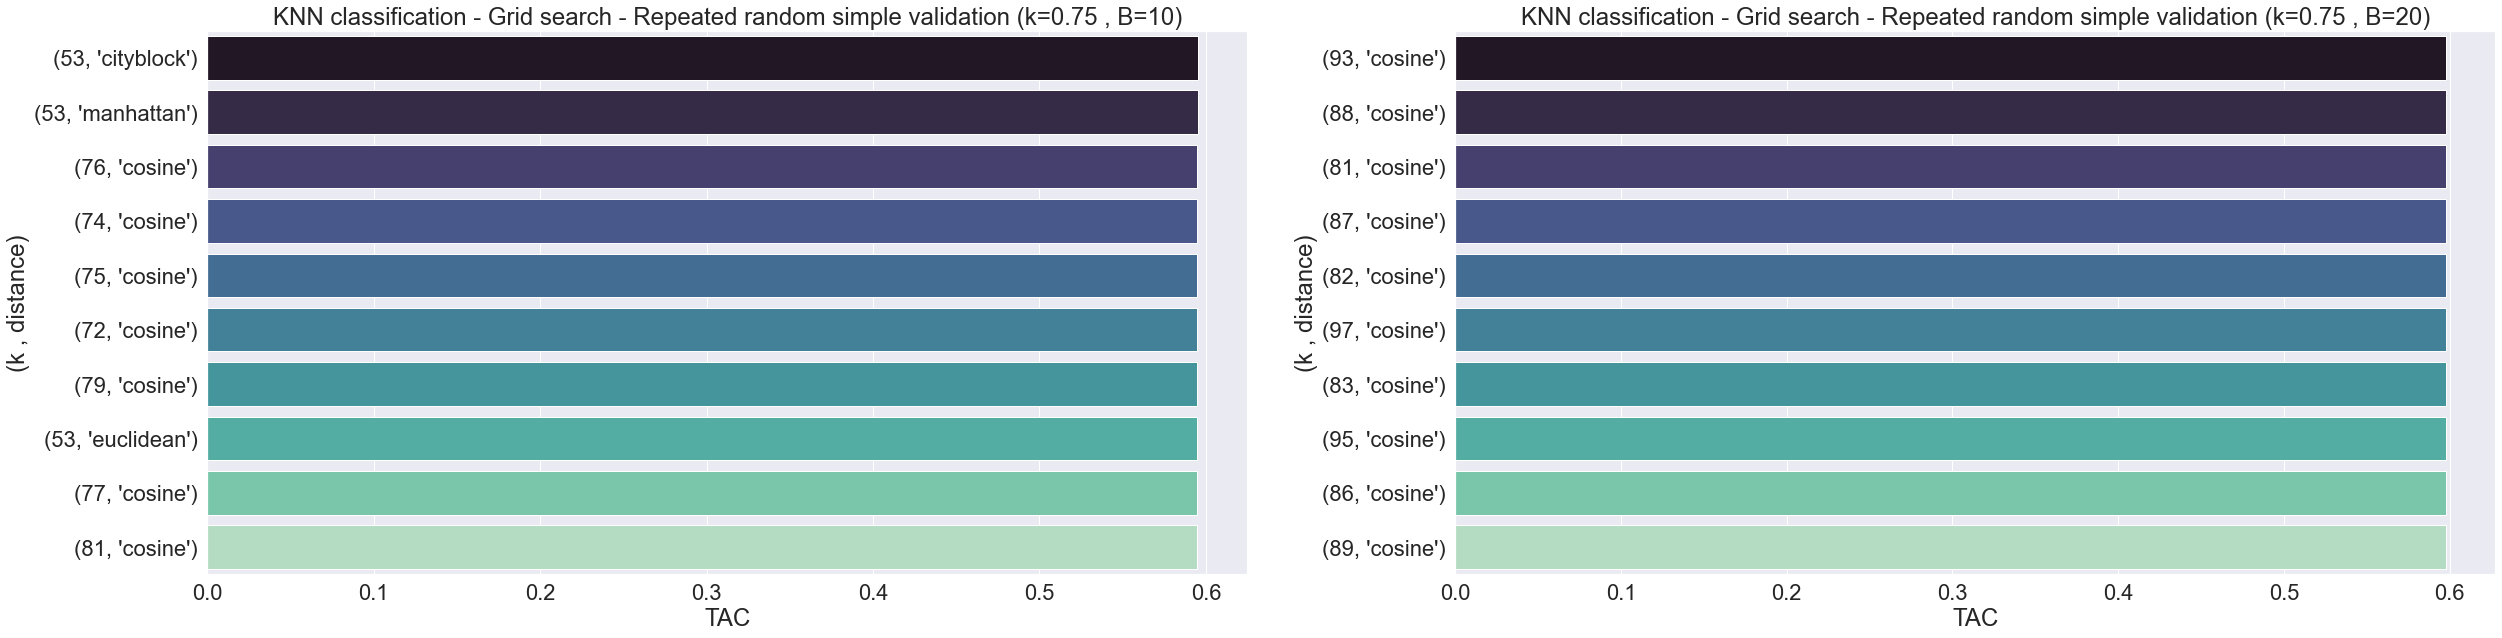

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_1_2.iloc[0:10 , :], palette='mako', ax=axs[0])

p2.title.set_text('KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=10)')

p4 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_2_2.iloc[0:10 , :], palette='mako', ax=axs[1])

p4.title.set_text('KNN classification - Grid search - Repeated random simple validation (k=0.75 , B=20)')

fig.savefig('p2big_1.jpg', format='jpg', dpi=750)

plt.show()

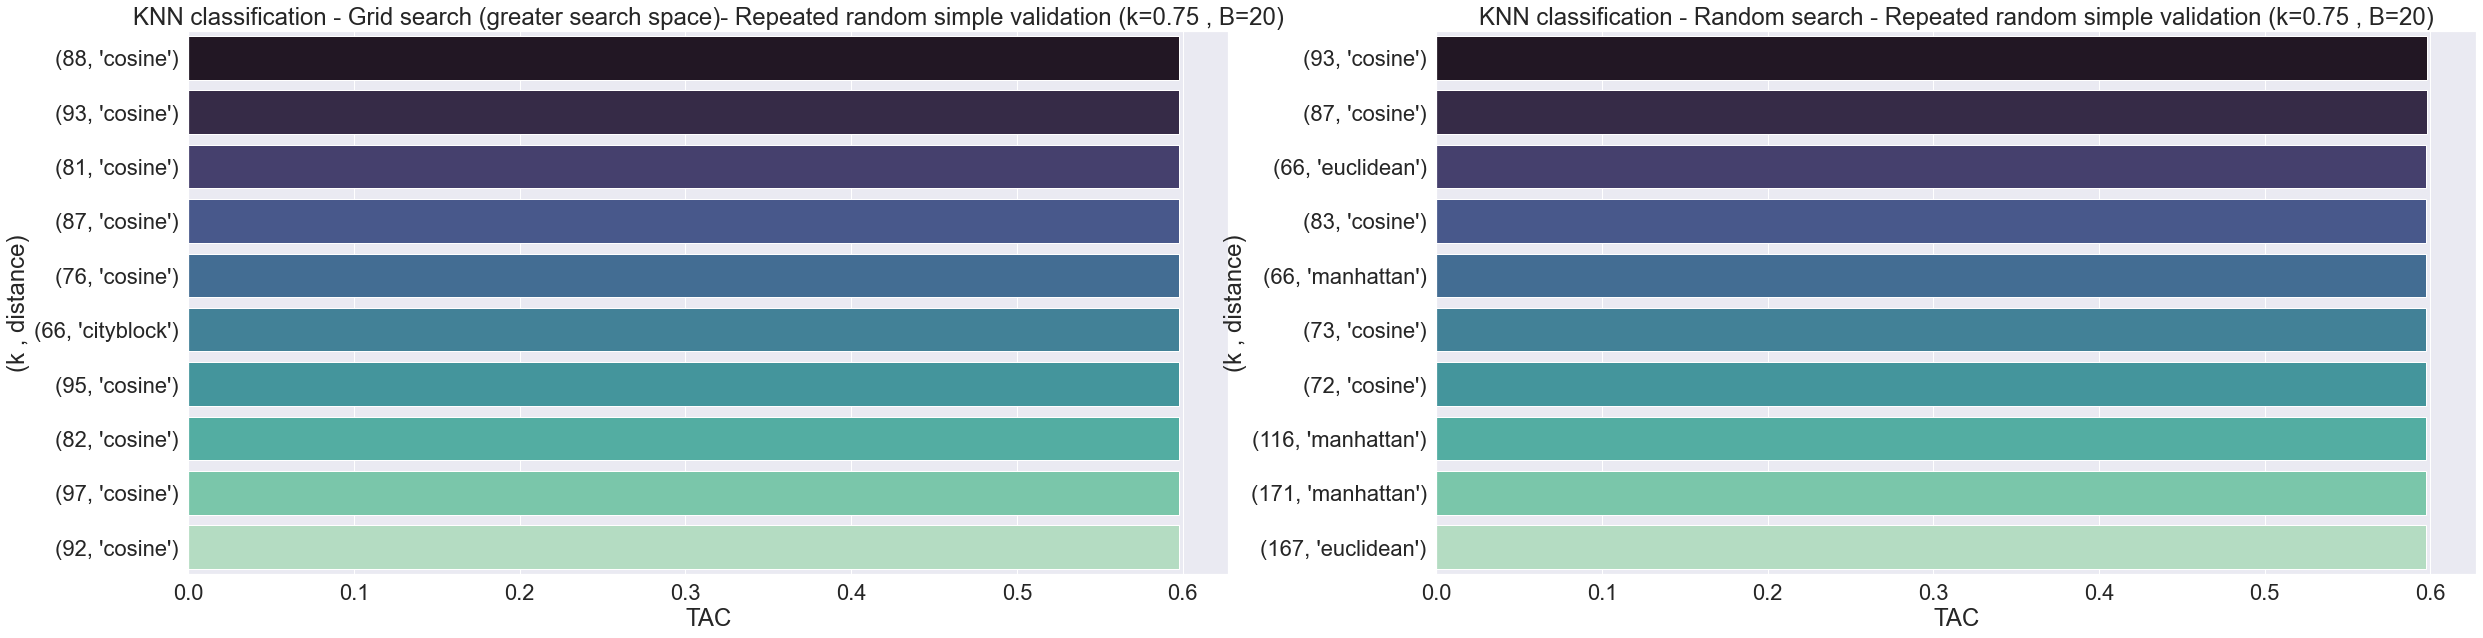

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p5_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_3_2.iloc[0:10 , :], palette='mako', ax=axs[0])

p5_2.title.set_text('KNN classification - Grid search (greater search space)- Repeated random simple validation (k=0.75 , B=20)')

p6_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_4_2.iloc[0:10 , :], palette='mako', ax=axs[1])

p6_2.title.set_text('KNN classification - Random search - Repeated random simple validation (k=0.75 , B=20)')

fig.savefig('p2big_2.jpg', format='jpg', dpi=750)

plt.show()

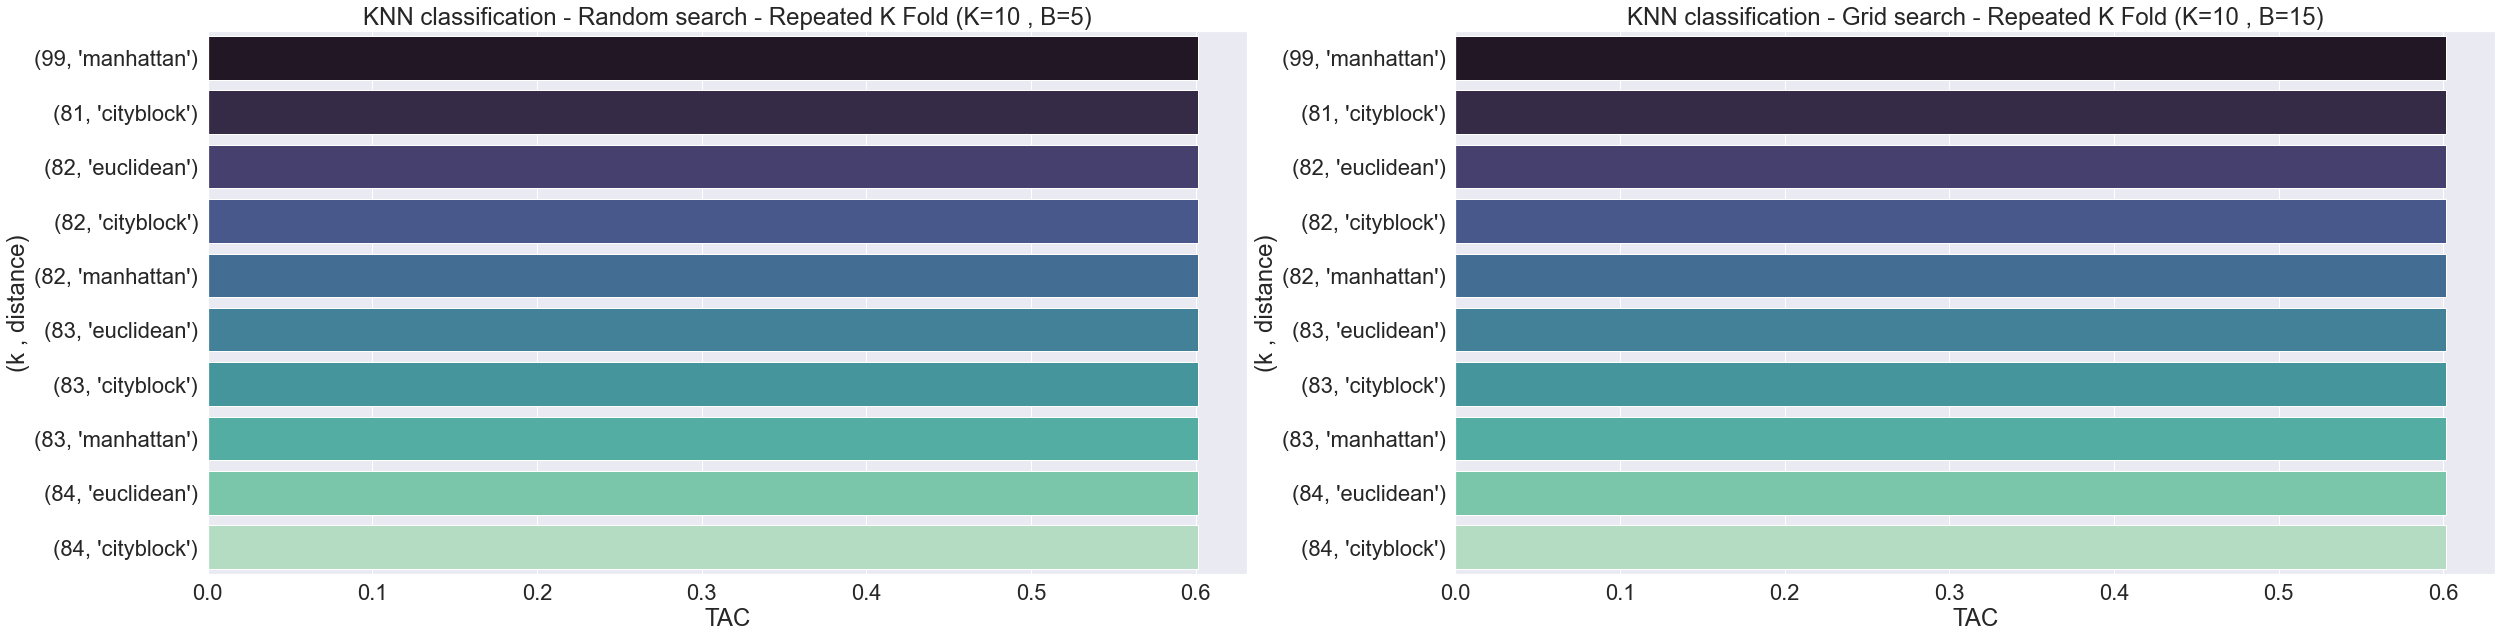

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p7_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_5_2.iloc[0:10 , :], palette='mako', ax=axs[0])

p7_2.title.set_text('KNN classification - Random search - Repeated K Fold (K=10 , B=5)')

p8_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_6_2.iloc[0:10 , :], palette='mako', ax=axs[1])

p8_2.title.set_text('KNN classification - Grid search - Repeated K Fold (K=10 , B=15)')

fig.savefig('p2big_3.jpg', format='jpg', dpi=750)

plt.show()

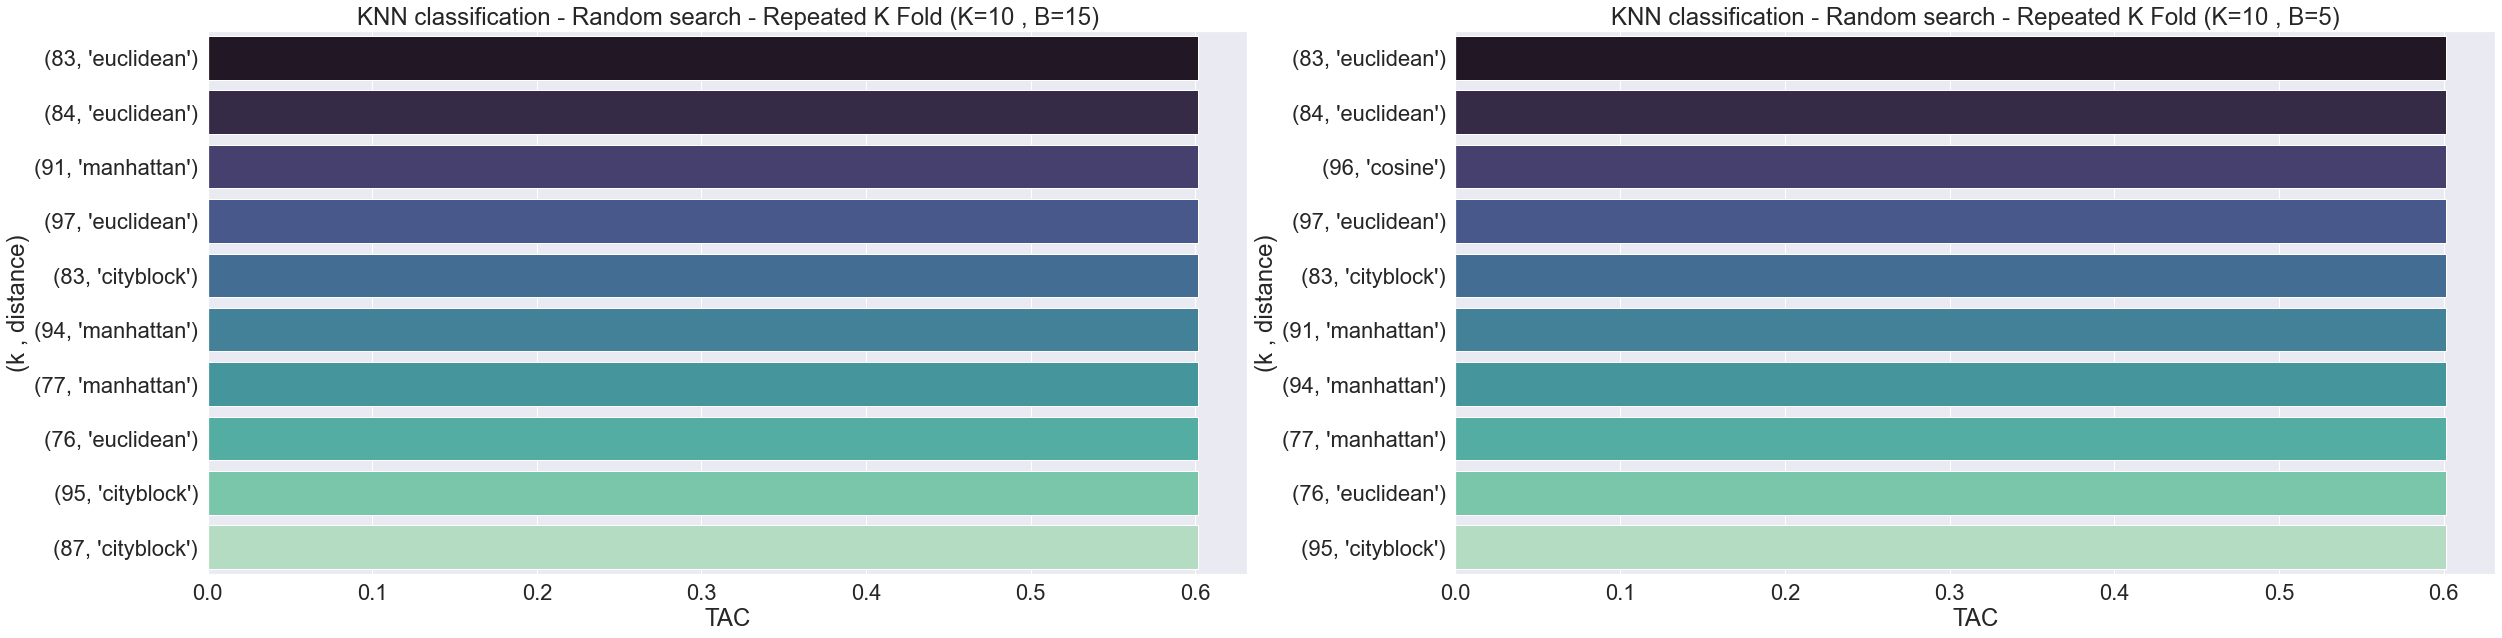

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(41, 10))

p9_2 = sns.barplot(x="TAC", y ='(k , distance)', data=Grid_search_7_2.iloc[0:10 , :], palette='mako', ax=axs[0])

p9_2.title.set_text('KNN classification - Random search - Repeated K Fold (K=10 , B=15)')

p10_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_8_2.iloc[0:10 , :], palette='mako', ax=axs[1])

p10_2.title.set_text('KNN classification - Random search - Repeated K Fold (K=10 , B=5)')

fig.savefig('p2big_4.jpg', format='jpg', dpi=750)

plt.show()

In [ ]:
sns.set(font_scale=1)

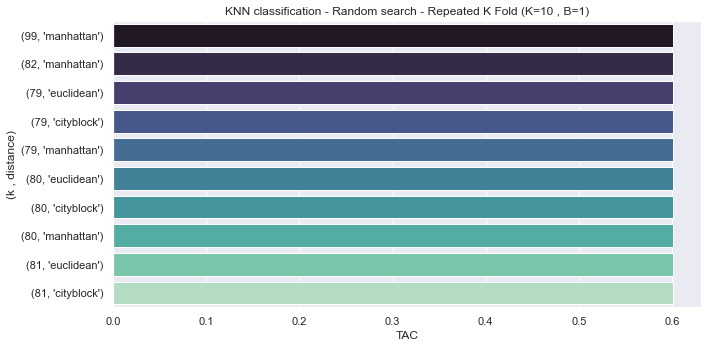

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))

p11_2 = sns.barplot(x="TAC", y ='(k , distance)' , data=Grid_search_9_2.iloc[0:10, :], palette='mako')

p11_2.title.set_text('KNN classification - Random search - Repeated K Fold (K=10 , B=1)')

plt.tight_layout()

fig.savefig('p2big_5.jpg', format='jpg', dpi=750)

plt.show()

# Ajuste de hiperparametros con `Sklearn`

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
knn_regression = sklearn.neighbors.KNeighborsRegressor( )

In [ ]:
grid_search = GridSearchCV(estimator = knn_regression, param_grid = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, scoring='neg_mean_squared_error')

In [ ]:
Y = Data.loc[:,'price']

X = Data.loc[:, Data.columns != 'price']

In [ ]:
grid_search.fit(X,Y)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'cosine', 'cityblock',
                                    'manhattan'],
                         'n_neighbors': range(1, 200)},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_estimator_

KNeighborsRegressor(metric='cosine', n_neighbors=17)

In [ ]:
grid_search.best_params_

{'metric': 'cosine', 'n_neighbors': 17}

In [ ]:
grid_search.best_score_

-2278523570223.8994

In [ ]:
df_grid_search_sklearn = pd.DataFrame({'k': grid_search.cv_results_['param_n_neighbors'], 'distance': grid_search.cv_results_['param_metric'] , 'ECM': - grid_search.cv_results_['mean_test_score']})


In [ ]:
df_grid_search_sklearn = df_grid_search_sklearn.sort_values(by='ECM', ascending=True)

df_grid_search_sklearn

,k,distance,ECM
215,17,cosine,2.278524e+12
209,11,cosine,2.287579e+12
214,16,cosine,2.300468e+12
216,18,cosine,2.305225e+12
210,12,cosine,2.308334e+12
...,...,...,...
794,198,manhattan,5.264590e+12
197,198,euclidean,5.266036e+12
198,199,euclidean,5.272047e+12
596,199,cityblock,5.273960e+12


In [ ]:
df_grid_search_sklearn['k'] = df_grid_search_sklearn['k'].astype(str) 

df_grid_search_sklearn['distance'] = df_grid_search_sklearn['distance'].astype(str)

In [ ]:
df_grid_search_sklearn['k-distance'] = df_grid_search_sklearn[['k', 'distance']].agg('-'.join, axis=1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
random_search = RandomizedSearchCV(estimator = knn_regression, param_distributions = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, n_iter=100, random_state=123, scoring='neg_mean_squared_error')

In [ ]:
random_search.fit(X,Y)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_iter=100,
                   param_distributions={'metric': ['euclidean', 'cosine',
                                                   'cityblock', 'manhattan'],
                                        'n_neighbors': range(1, 200)},
                   random_state=123, scoring='neg_mean_squared_error')

In [ ]:
df_random_search_sklearn = pd.DataFrame({'k': random_search.cv_results_['param_n_neighbors'], 'distance': random_search.cv_results_['param_metric'] , 'ECM': - random_search.cv_results_['mean_test_score']})

In [ ]:
df_random_search_sklearn = df_random_search_sklearn.sort_values(by='ECM', ascending=True)
df_random_search_sklearn

,k,distance,ECM
18,11,cosine,2.287579e+12
38,11,manhattan,2.321534e+12
91,14,euclidean,2.334281e+12
84,19,cosine,2.337300e+12
78,12,euclidean,2.339571e+12
...,...,...,...
60,189,cityblock,5.180324e+12
43,189,euclidean,5.182189e+12
46,190,cityblock,5.187852e+12
17,194,manhattan,5.227831e+12


In [ ]:
df_random_search_sklearn['k'] = df_random_search_sklearn['k'].astype(str) 

df_random_search_sklearn['distance'] = df_random_search_sklearn['distance'].astype(str)

In [ ]:
df_random_search_sklearn['k-distance'] = df_random_search_sklearn[['k', 'distance']].agg('-'.join, axis=1)

In [ ]:
df_grid_search_sklearn

,k,distance,ECM,k-distance
215,17,cosine,2.278524e+12,17-cosine
209,11,cosine,2.287579e+12,11-cosine
214,16,cosine,2.300468e+12,16-cosine
216,18,cosine,2.305225e+12,18-cosine
210,12,cosine,2.308334e+12,12-cosine
...,...,...,...,...
794,198,manhattan,5.264590e+12,198-manhattan
197,198,euclidean,5.266036e+12,198-euclidean
198,199,euclidean,5.272047e+12,199-euclidean
596,199,cityblock,5.273960e+12,199-cityblock


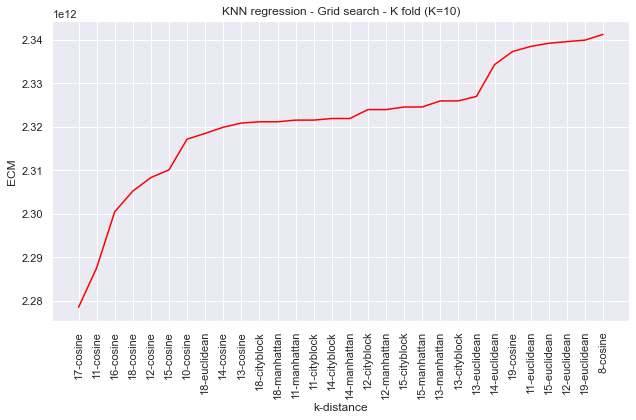

In [ ]:
fig, axs = plt.subplots()

p1 = sns.lineplot(y="ECM", x='k-distance' , data=df_grid_search_sklearn.iloc[0:30, :], color='red')

plt.setp(p1.get_xticklabels(), rotation=90)

p1.title.set_text('KNN regression - Grid search - K fold (K=10)')

plt.tight_layout()

fig.savefig('pp1.jpg', format='jpg', dpi=1200)

plt.show()

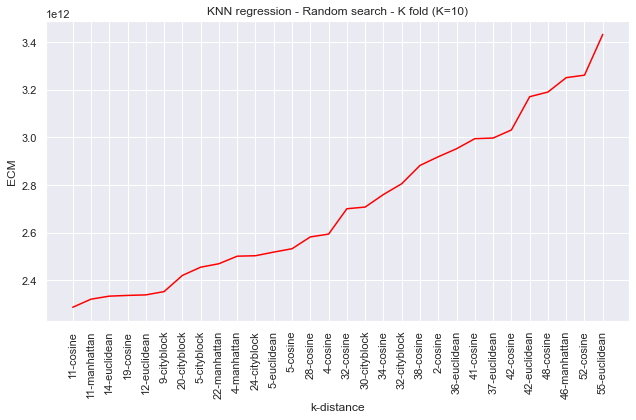

In [ ]:
fig, axs = plt.subplots()

p2 = sns.lineplot(y="ECM", x='k-distance' , data=df_random_search_sklearn.iloc[0:30, :], color='red')

plt.setp(p2.get_xticklabels(), rotation=90)

p2.title.set_text('KNN regression - Random search - K fold (K=10)')

plt.tight_layout()

fig.savefig('pp2.jpg', format='jpg', dpi=1200)

plt.show()

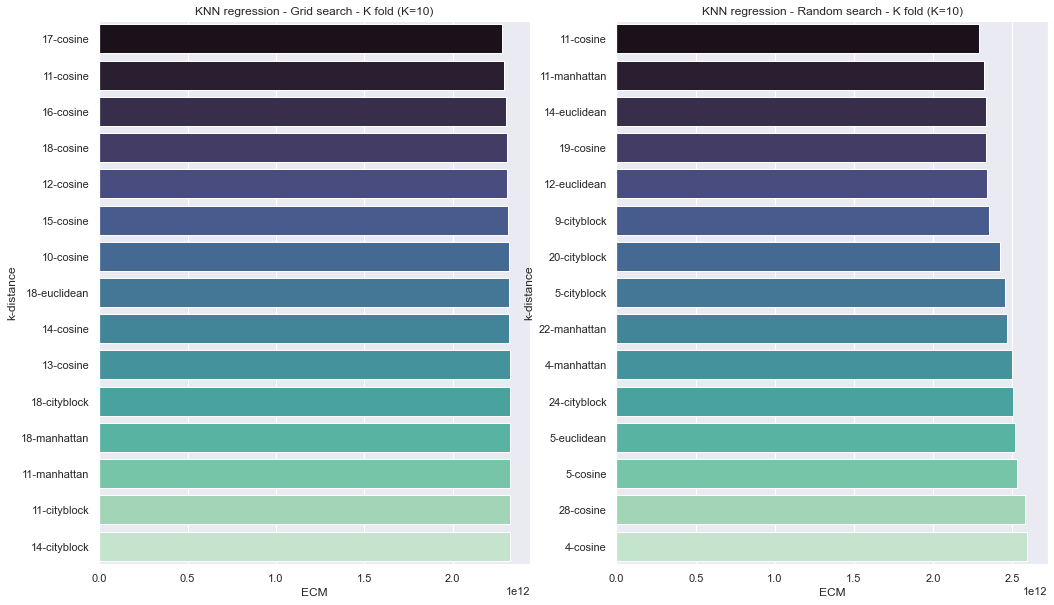

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(17, 10))

p1 = sns.barplot(x="ECM", y ='k-distance' , data=df_grid_search_sklearn.iloc[0:15, :], palette='mako', ax=axs[0])

p1.title.set_text('KNN regression - Grid search - K fold (K=10)')

p2 = sns.barplot(x="ECM", y ='k-distance' , data=df_random_search_sklearn.iloc[0:15, :], palette='mako', ax=axs[1])

p2.title.set_text('KNN regression - Random search - K fold (K=10)')

fig.savefig('p3big.jpg', format='jpg', dpi=1200)

plt.show()

### Repetir lo anterior con knn classification y Accuracy (TAC),  con Sklearn.

In [ ]:
knn_classification = sklearn.neighbors.KNeighborsClassifier( )

In [ ]:
grid_search = GridSearchCV(estimator = knn_classification, param_grid = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, scoring='accuracy')

In [ ]:
Y = Data.loc[:,'quality_recode']

X = Data.loc[:, Data.columns != 'quality_recode']

In [ ]:
grid_search.fit(X,Y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'cosine', 'cityblock',
                                    'manhattan'],
                         'n_neighbors': range(1, 200)},
             scoring='accuracy')

In [ ]:
grid_search.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=34)

In [ ]:
grid_search.best_score_

0.6036731882061174

In [ ]:
df_grid_search_sklearn = pd.DataFrame({'k': grid_search.cv_results_['param_n_neighbors'], 'distance': grid_search.cv_results_['param_metric'] , 'TAC': grid_search.cv_results_['mean_test_score']})


In [ ]:
df_grid_search_sklearn = df_grid_search_sklearn.sort_values(by='TAC', ascending=False)

df_grid_search_sklearn

,k,distance,TAC
33,34,euclidean,0.603673
795,199,manhattan,0.601573
503,106,cityblock,0.601573
496,99,cityblock,0.601573
497,100,cityblock,0.601573
...,...,...,...
401,4,cityblock,0.460890
200,2,cosine,0.410485
598,2,manhattan,0.394762
399,2,cityblock,0.394762


In [ ]:
df_grid_search_sklearn['k'] = df_grid_search_sklearn['k'].astype(str) 

df_grid_search_sklearn['distance'] = df_grid_search_sklearn['distance'].astype(str)

In [ ]:
df_grid_search_sklearn['k-distance'] = df_grid_search_sklearn[['k', 'distance']].agg('-'.join, axis=1)

In [ ]:
random_search = RandomizedSearchCV(estimator = knn_classification, param_distributions = {'n_neighbors': range(1,200), 'metric': ['euclidean','cosine','cityblock','manhattan']}, cv = 10, n_iter=100, random_state=123, scoring='accuracy')

In [ ]:
random_search.fit(X,Y)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'metric': ['euclidean', 'cosine',
                                                   'cityblock', 'manhattan'],
                                        'n_neighbors': range(1, 200)},
                   random_state=123, scoring='accuracy')

In [ ]:
df_random_search_sklearn = pd.DataFrame({'k': random_search.cv_results_['param_n_neighbors'], 'distance': random_search.cv_results_['param_metric'] , 'TAC': random_search.cv_results_['mean_test_score']})

In [ ]:
df_random_search_sklearn = df_random_search_sklearn.sort_values(by='TAC', ascending=False)
df_random_search_sklearn

,k,distance,TAC
50,101,cityblock,0.601573
69,92,euclidean,0.601573
32,156,cityblock,0.601573
33,173,euclidean,0.601573
80,97,manhattan,0.601573
...,...,...,...
57,5,euclidean,0.517093
70,5,cosine,0.515999
14,4,cosine,0.482937
4,4,manhattan,0.460890


In [ ]:
df_random_search_sklearn['k'] = df_random_search_sklearn['k'].astype(str) 

df_random_search_sklearn['distance'] = df_random_search_sklearn['distance'].astype(str)

In [ ]:
df_random_search_sklearn['k-distance'] = df_random_search_sklearn[['k', 'distance']].agg('-'.join, axis=1)

In [ ]:
df_grid_search_sklearn

,k,distance,TAC,k-distance
33,34,euclidean,0.603673,34-euclidean
795,199,manhattan,0.601573,199-manhattan
503,106,cityblock,0.601573,106-cityblock
496,99,cityblock,0.601573,99-cityblock
497,100,cityblock,0.601573,100-cityblock
...,...,...,...,...
401,4,cityblock,0.460890,4-cityblock
200,2,cosine,0.410485,2-cosine
598,2,manhattan,0.394762,2-manhattan
399,2,cityblock,0.394762,2-cityblock


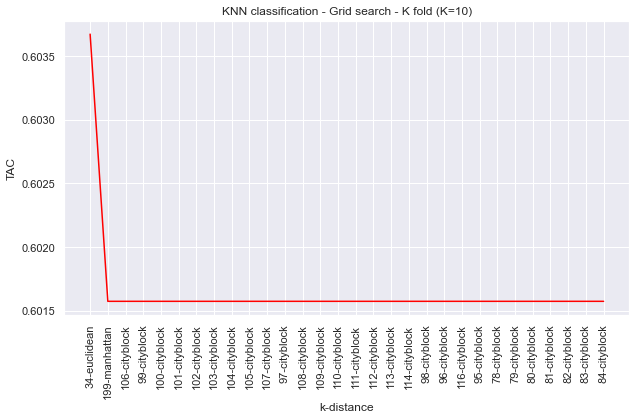

In [ ]:
fig, axs = plt.subplots()

p1 = sns.lineplot(y="TAC", x='k-distance' , data=df_grid_search_sklearn.iloc[0:30, :], color='red')

plt.setp(p1.get_xticklabels(), rotation=90)

p1.title.set_text('KNN classification - Grid search - K fold (K=10)')

plt.tight_layout()

fig.savefig('pp3.jpg', format='jpg', dpi=1200)

plt.show()


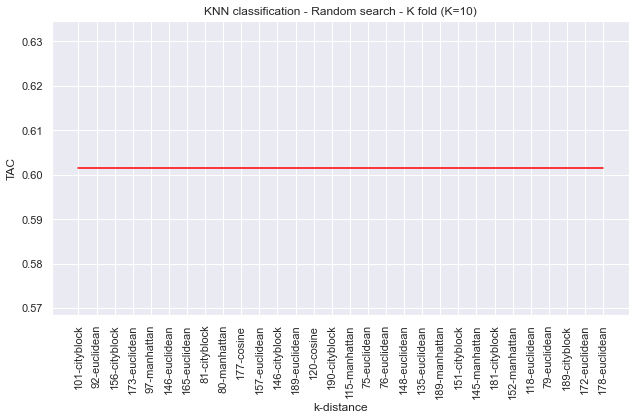

In [ ]:
fig, axs = plt.subplots()

p2 = sns.lineplot(y="TAC", x='k-distance' , data=df_random_search_sklearn.iloc[0:30, :], color='red')

plt.setp(p2.get_xticklabels(), rotation=90)

p2.title.set_text('KNN classification - Random search - K fold (K=10)')

plt.tight_layout()

fig.savefig('pp4.jpg', format='jpg', dpi=1200)

plt.show()

## Grid search como metodo de optimizacion de funciones matematicas

In [ ]:
values = []

for x in range(-99999 , 99999) :

    values.append( x**2 )


In [ ]:
df = pd.DataFrame({'x':range(-99999 , 99999)  , 'f(x)':values})

In [ ]:
df.sort_values(by='f(x)')

,x,f(x)
99999,0,0
99998,-1,1
100000,1,1
100001,2,4
99997,-2,4
...,...,...
2,-99997,9999400009
199996,99997,9999400009
199997,99998,9999600004
1,-99998,9999600004


In [ ]:
values , Search_Space_list = [] , []

Search_Space_1 = range(-100 , 100)

Search_Space_2 = range(-100 , 100)

hyperparameter_combinations = list( itertools.product(Search_Space_1, Search_Space_2) )

for x in hyperparameter_combinations :

    Search_Space_list.append(x)

    values.append( x[0]**2 + x[1]**2)


In [ ]:
df = pd.DataFrame({'(x_1,x_2)':Search_Space_list , 'f(x_1,x_2)':values})

In [ ]:
df.sort_values(by='f(x_1,x_2)', ascending=True )

,"(x_1,x_2)","f(x_1,x_2)"
20100,"(0, 0)",0
20101,"(0, 1)",1
20300,"(1, 0)",1
20099,"(0, -1)",1
19900,"(-1, 0)",1
...,...,...
39800,"(99, -100)",19801
200,"(-99, -100)",19801
199,"(-100, 99)",19801
1,"(-100, -99)",19801
